In [16]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

def get_df(path, type_, mod, ds):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['name','cancer_score']
    df['type'] = type_
    df['model'] = mod  
    df['data'] = ds
    return df

import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
sns.set_style('darkgrid')
from src.plots import boxplot_cs
import warnings
warnings.filterwarnings(action='ignore',)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using : cuda


In [2]:
l1 = [os.path.join('../DEEPCAT_predictions/',x) for x in os.listdir('../DEEPCAT_predictions/')]
l2 = [os.path.join('../output/predicted_scores/ostmeyer_breast',x) for x in os.listdir('../output/predicted_scores/ostmeyer_breast')]

Here PVAL
LDAKFSODFSAD True
Here PVAL


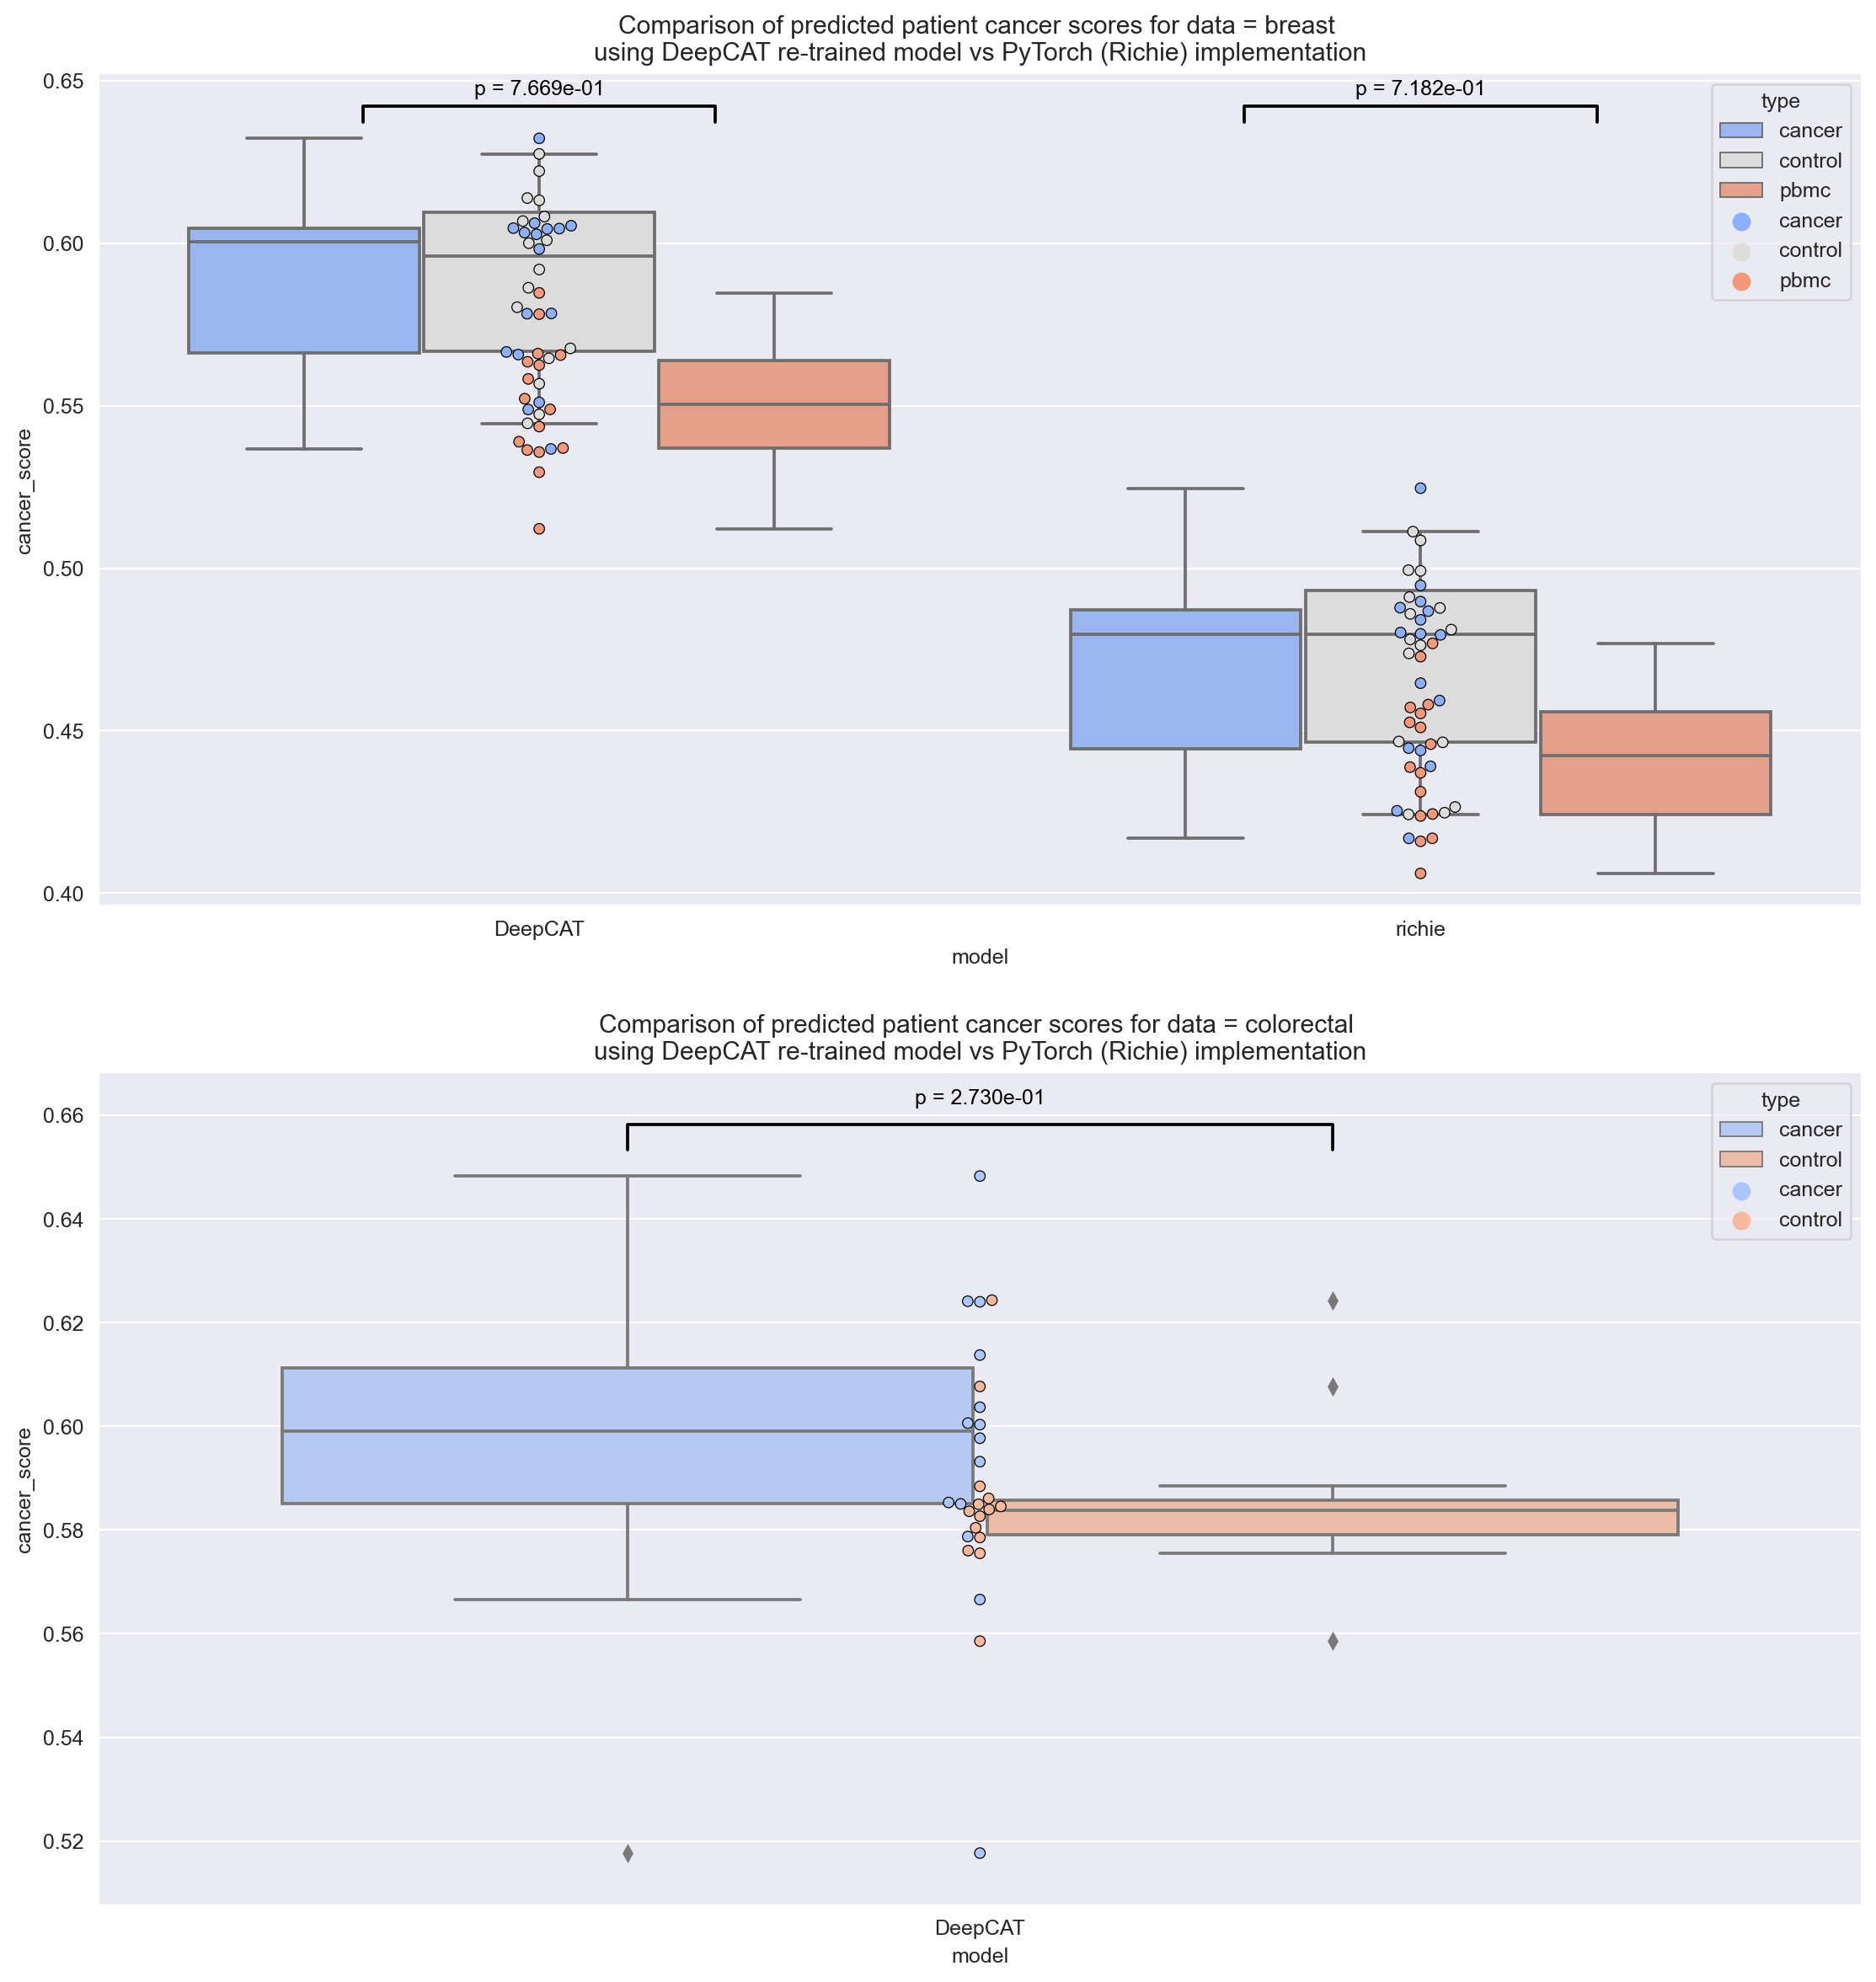

In [36]:
mod = 'DeepCAT'
br_ca = get_df(l1[0], 'cancer', mod, 'breast')
#br_con = get_df(l1[1],'control',mod,'breast')
br_pbmc = get_df(l1[2],'pbmc',mod,'breast')

rich_br_ca = get_df(l2[0], 'cancer', 'richie', 'breast')
#rich_br_con = get_df(l2[1],'control','richie','breast')
rich_br_pbmc = get_df(l2[2],'pbmc','richie','breast')

colo_ca = get_df(l1[-2], 'cancer',mod,'colorectal')
colo_con = get_df(l1[-1], 'control',mod,'colorectal')
total = pd.concat([br_ca,
                   br_con,
                   br_pbmc, 
                   rich_br_ca,
                   rich_br_con,
                   rich_br_pbmc,
                   colo_ca, 
                   colo_con], ignore_index=True)
boxplot_cs(total,True)

In [297]:
PS = '../output/predicted_scores/new_comparison/'
folders = [PS+x+'/' for x in os.listdir(PS)]
results = pd.DataFrame()
for f in folders:
    #if 'ismart' in f: continue
     #   print("here",f)
     #   continue
    files = os.listdir(f)
    scores = [x for x in files if x.endswith('.txt') and 'cancer_scores' in x]
    for sc in scores:
        filename = os.path.join(f,sc)
        label = sc.split('_cancer_scores.txt')[0] #Dataset name
        temp = get_df(filename, type_='', mod='richie',ds=label)
        results = results.append(temp, ignore_index=True)
        
results.data.unique()
mapp= {'breast_cancer':'cancer',
       'breast_control':'control',
       'BRCA':'cancer',
       'CTRL':'control',
       'beausang_BRCA':'cancer',
       'emerson_CTRL':'control',
       'brca_pbmc':'cancer',
       'brca_pbmc_ismart':'cancer',
       'MCC_LN':'control',
       'MCC_pbmc':'cancer',
       'MCC_tumor':'cancer',
       'cystic_fibrosis':'control',
       'emerson_batch1':'control',
       'ostmeyer_colorectal_Cancer':'cancer',
       'ostmeyer_colorectal_Control':'control',
       'YFV_pbmc':'control',
       'YFV_activated':'control',
       'breast_cancer_ismart':'cancer',
       'breast_control_ismart':'control', 
       'LN_ismart':'control',
       'pbmc_ismart':'cancer',
       'tumor_ismart':'cancer',
       'cystic_fibrosis_ismart':'control',
       'emerson_batch1_ismart':'control', 
       'ostmeyer_colorectal_ismart_Cancer':'cancer',
       'ostmeyer_colorectal_ismart_Control':'control', 
       'beausang_brca_ismart':'cancer',
       'emerson_ctrl_ismart':'control', 
       'YFV_activated_ismart':'control', 
       'YFV_pbmc_ismart':'control'}

results.loc[results['data'] == "YFW_activated", 'data'] = 'YFV_activated'
results['type'] = results.apply(lambda x : mapp[x['data']],axis=1)
results['dummy']='all'
results['ismart'] = results.data.str.contains('ismart')        
results.sample(5)
#results.sort_values('type', ascending=False, inplace=True)

,name,cancer_score,type,model,data,dummy,ismart
715,HIP13185.tsv,0.207483,control,richie,emerson_batch1_ismart,all,True
481,118_B.tsv,0.560540,control,richie,cystic_fibrosis_ismart,all,True
454,HIP13869.tsv,0.449960,control,richie,emerson_batch1,all,False
529,HIP01004.tsv,0.194363,control,richie,emerson_batch1_ismart,all,True
273,HIP05398.tsv,0.455720,control,richie,emerson_batch1,all,False


In [213]:
results.data.unique()

array(['breast_cancer', 'breast_control', 'breast_cancer_ismart',
       'breast_control_ismart', 'MCC_LN', 'MCC_pbmc', 'MCC_tumor',
       'LN_ismart', 'pbmc_ismart', 'tumor_ismart', 'cystic_fibrosis',
       'emerson_batch1', 'cystic_fibrosis_ismart',
       'emerson_batch1_ismart', 'ostmeyer_colorectal_ismart_Cancer',
       'ostmeyer_colorectal_ismart_Control', 'ostmeyer_colorectal_Cancer',
       'ostmeyer_colorectal_Control', 'beausang_BRCA', 'emerson_CTRL',
       'beausang_brca_ismart', 'emerson_ctrl_ismart', 'YFV_activated',
       'YFV_pbmc', 'YFV_activated_ismart', 'YFV_pbmc_ismart'],
      dtype=object)

In [286]:
def box(df, title='Boxplot', **kwargs):
    f,a = plt.subplots(1,1, figsize=(15,9))
    sns.boxplot(data=df, x='cancer_score', y='data', orient='h', **kwargs)
    sns.swarmplot(data=df, x='cancer_score', y='data', orient='h', ax = a, 
                  edgecolor='black', linewidth=0.5, size = 3, **kwargs)
    a.set_title(title, fontweight='bold',fontsize=18)
    return a

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the

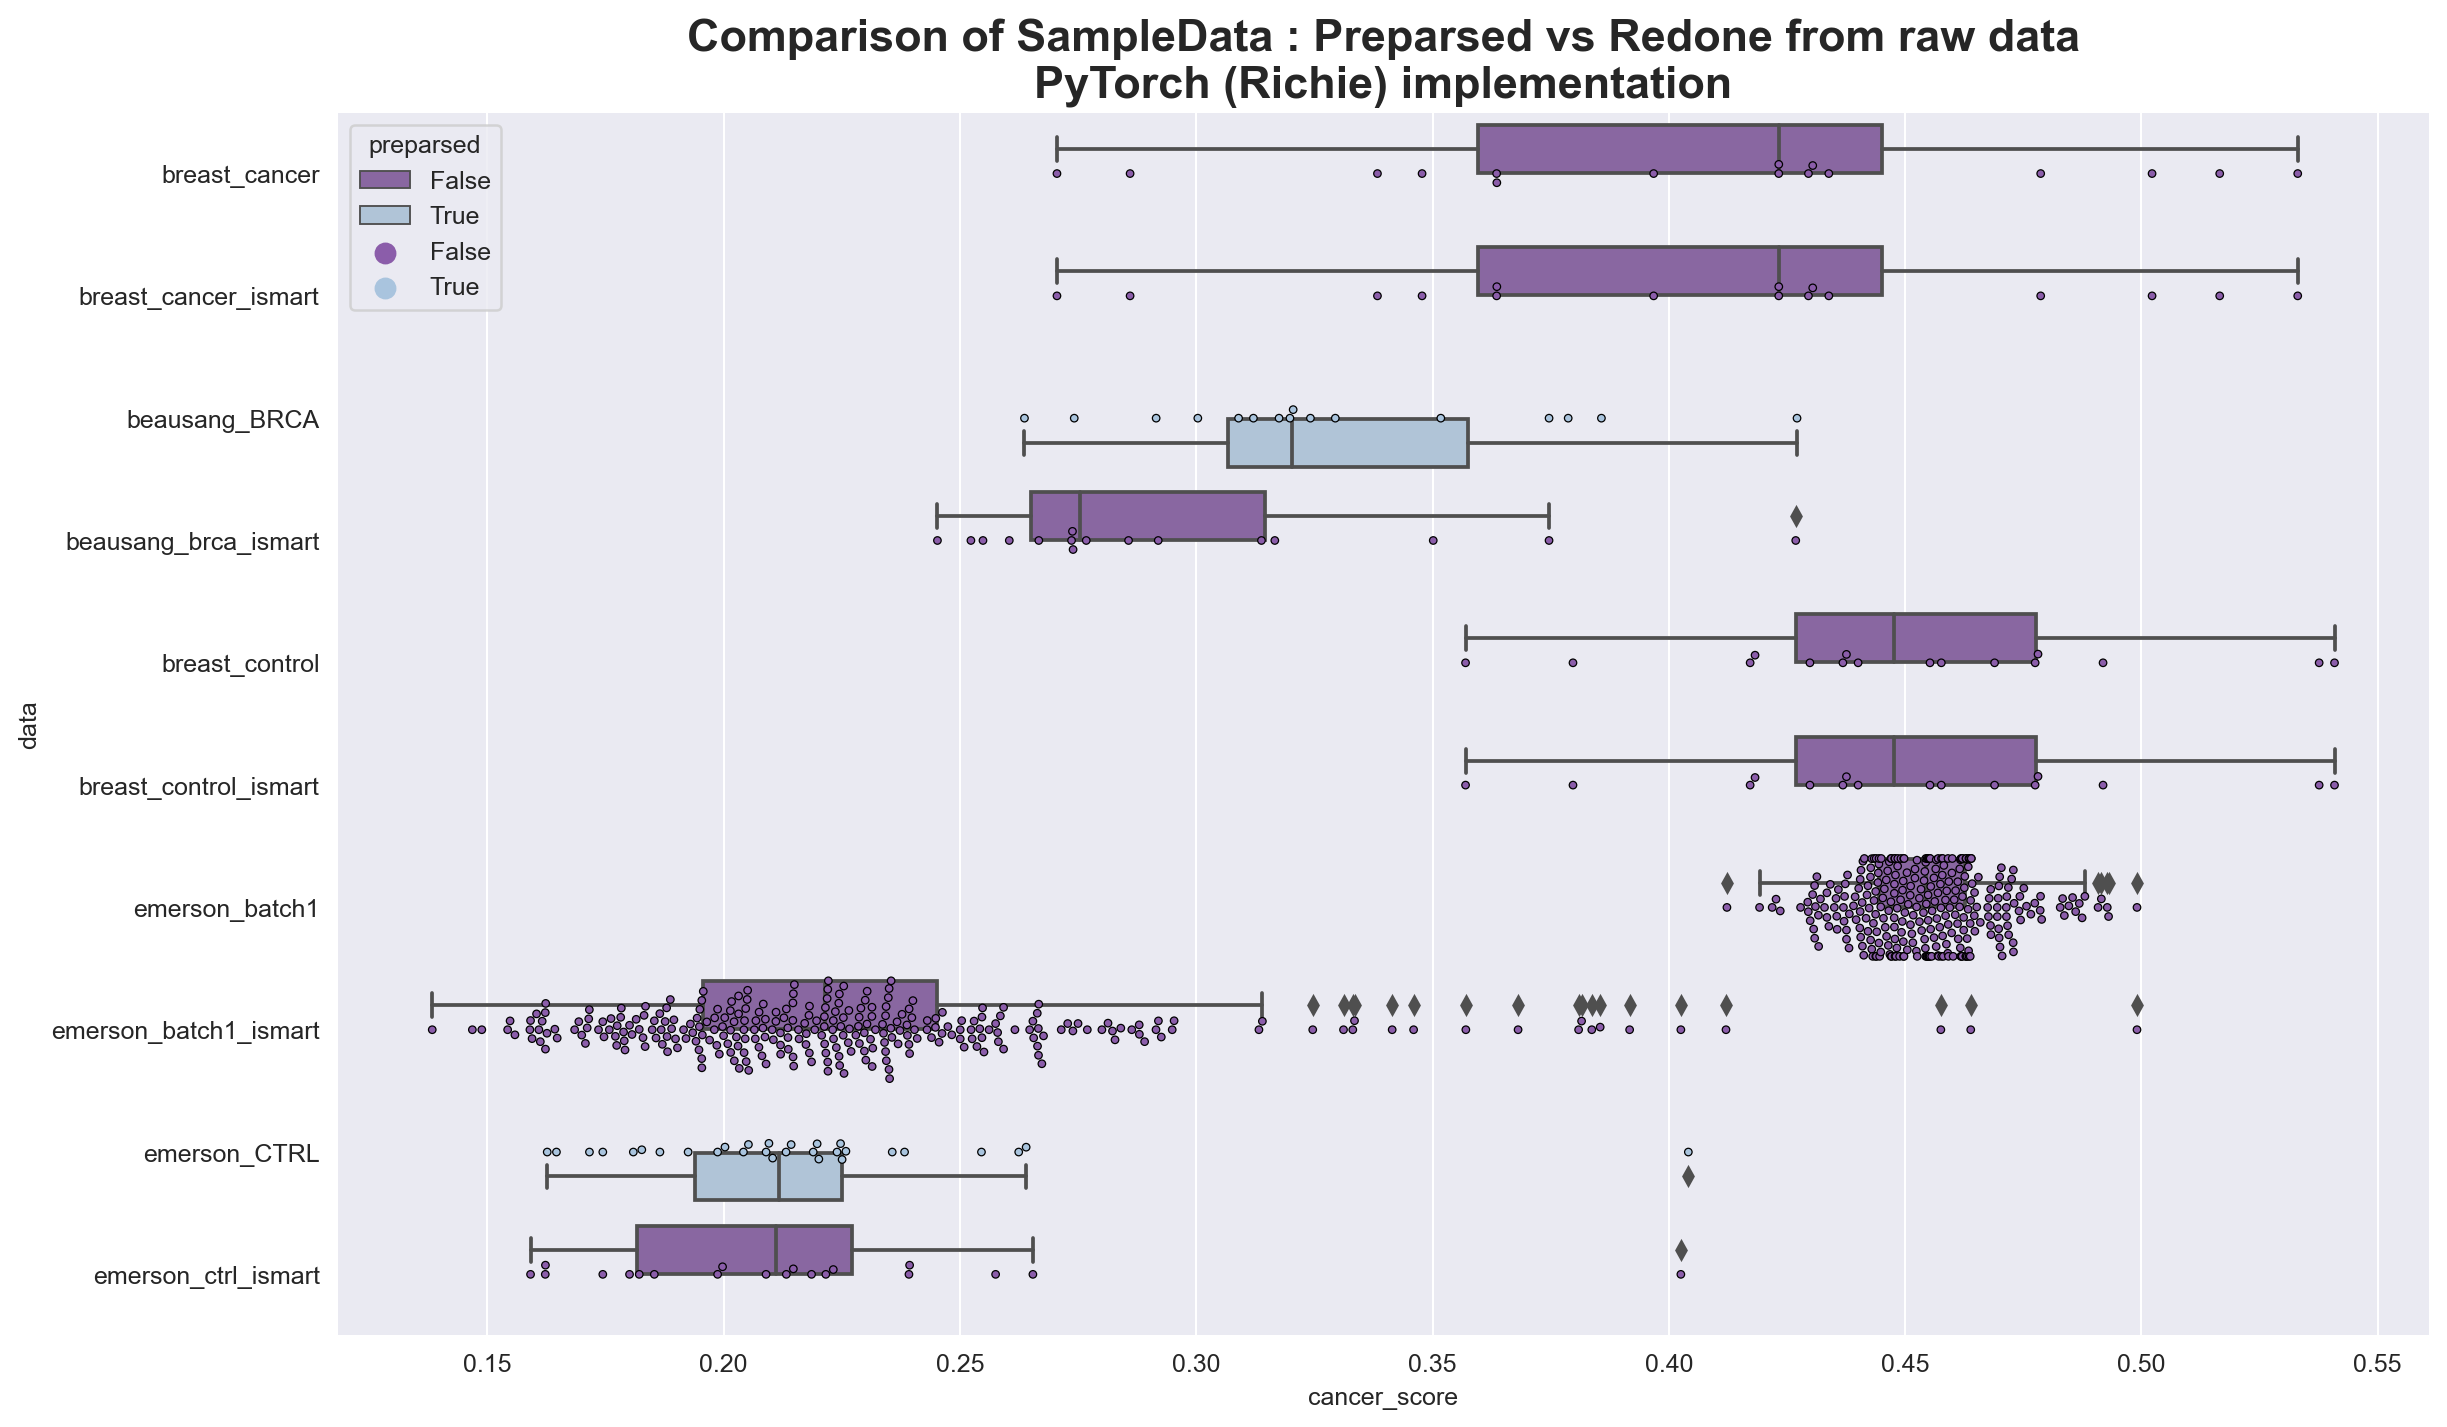

In [262]:
group1 = results.query('data.str.contains("breast") or data.str.contains("emerson")'\
                       'or data.str.contains("brca") or data.str.contains("beausang")')
mask1 = group1['data']=="beausang_BRCA"
mask2 = group1['data']=="emerson_CTRL"
m = mask1|mask2
group1.loc[m, 'preparsed']=True
group1.loc[~m, 'preparsed']=False
#f,a = plt.subplots(1,1, figsize=(15,9))
sns.set_palette('BuPu_r',n_colors=2)

box(group1, title = 'Comparison of SampleData : Preparsed vs Redone from raw data\nPyTorch (Richie) implementation',
    order = ['breast_cancer', 'breast_cancer_ismart','beausang_BRCA', 'beausang_brca_ismart', 'breast_control',
                              'breast_control_ismart', 'emerson_batch1', 'emerson_batch1_ismart','emerson_CTRL', 'emerson_ctrl_ismart'],
   hue = 'preparsed')


C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


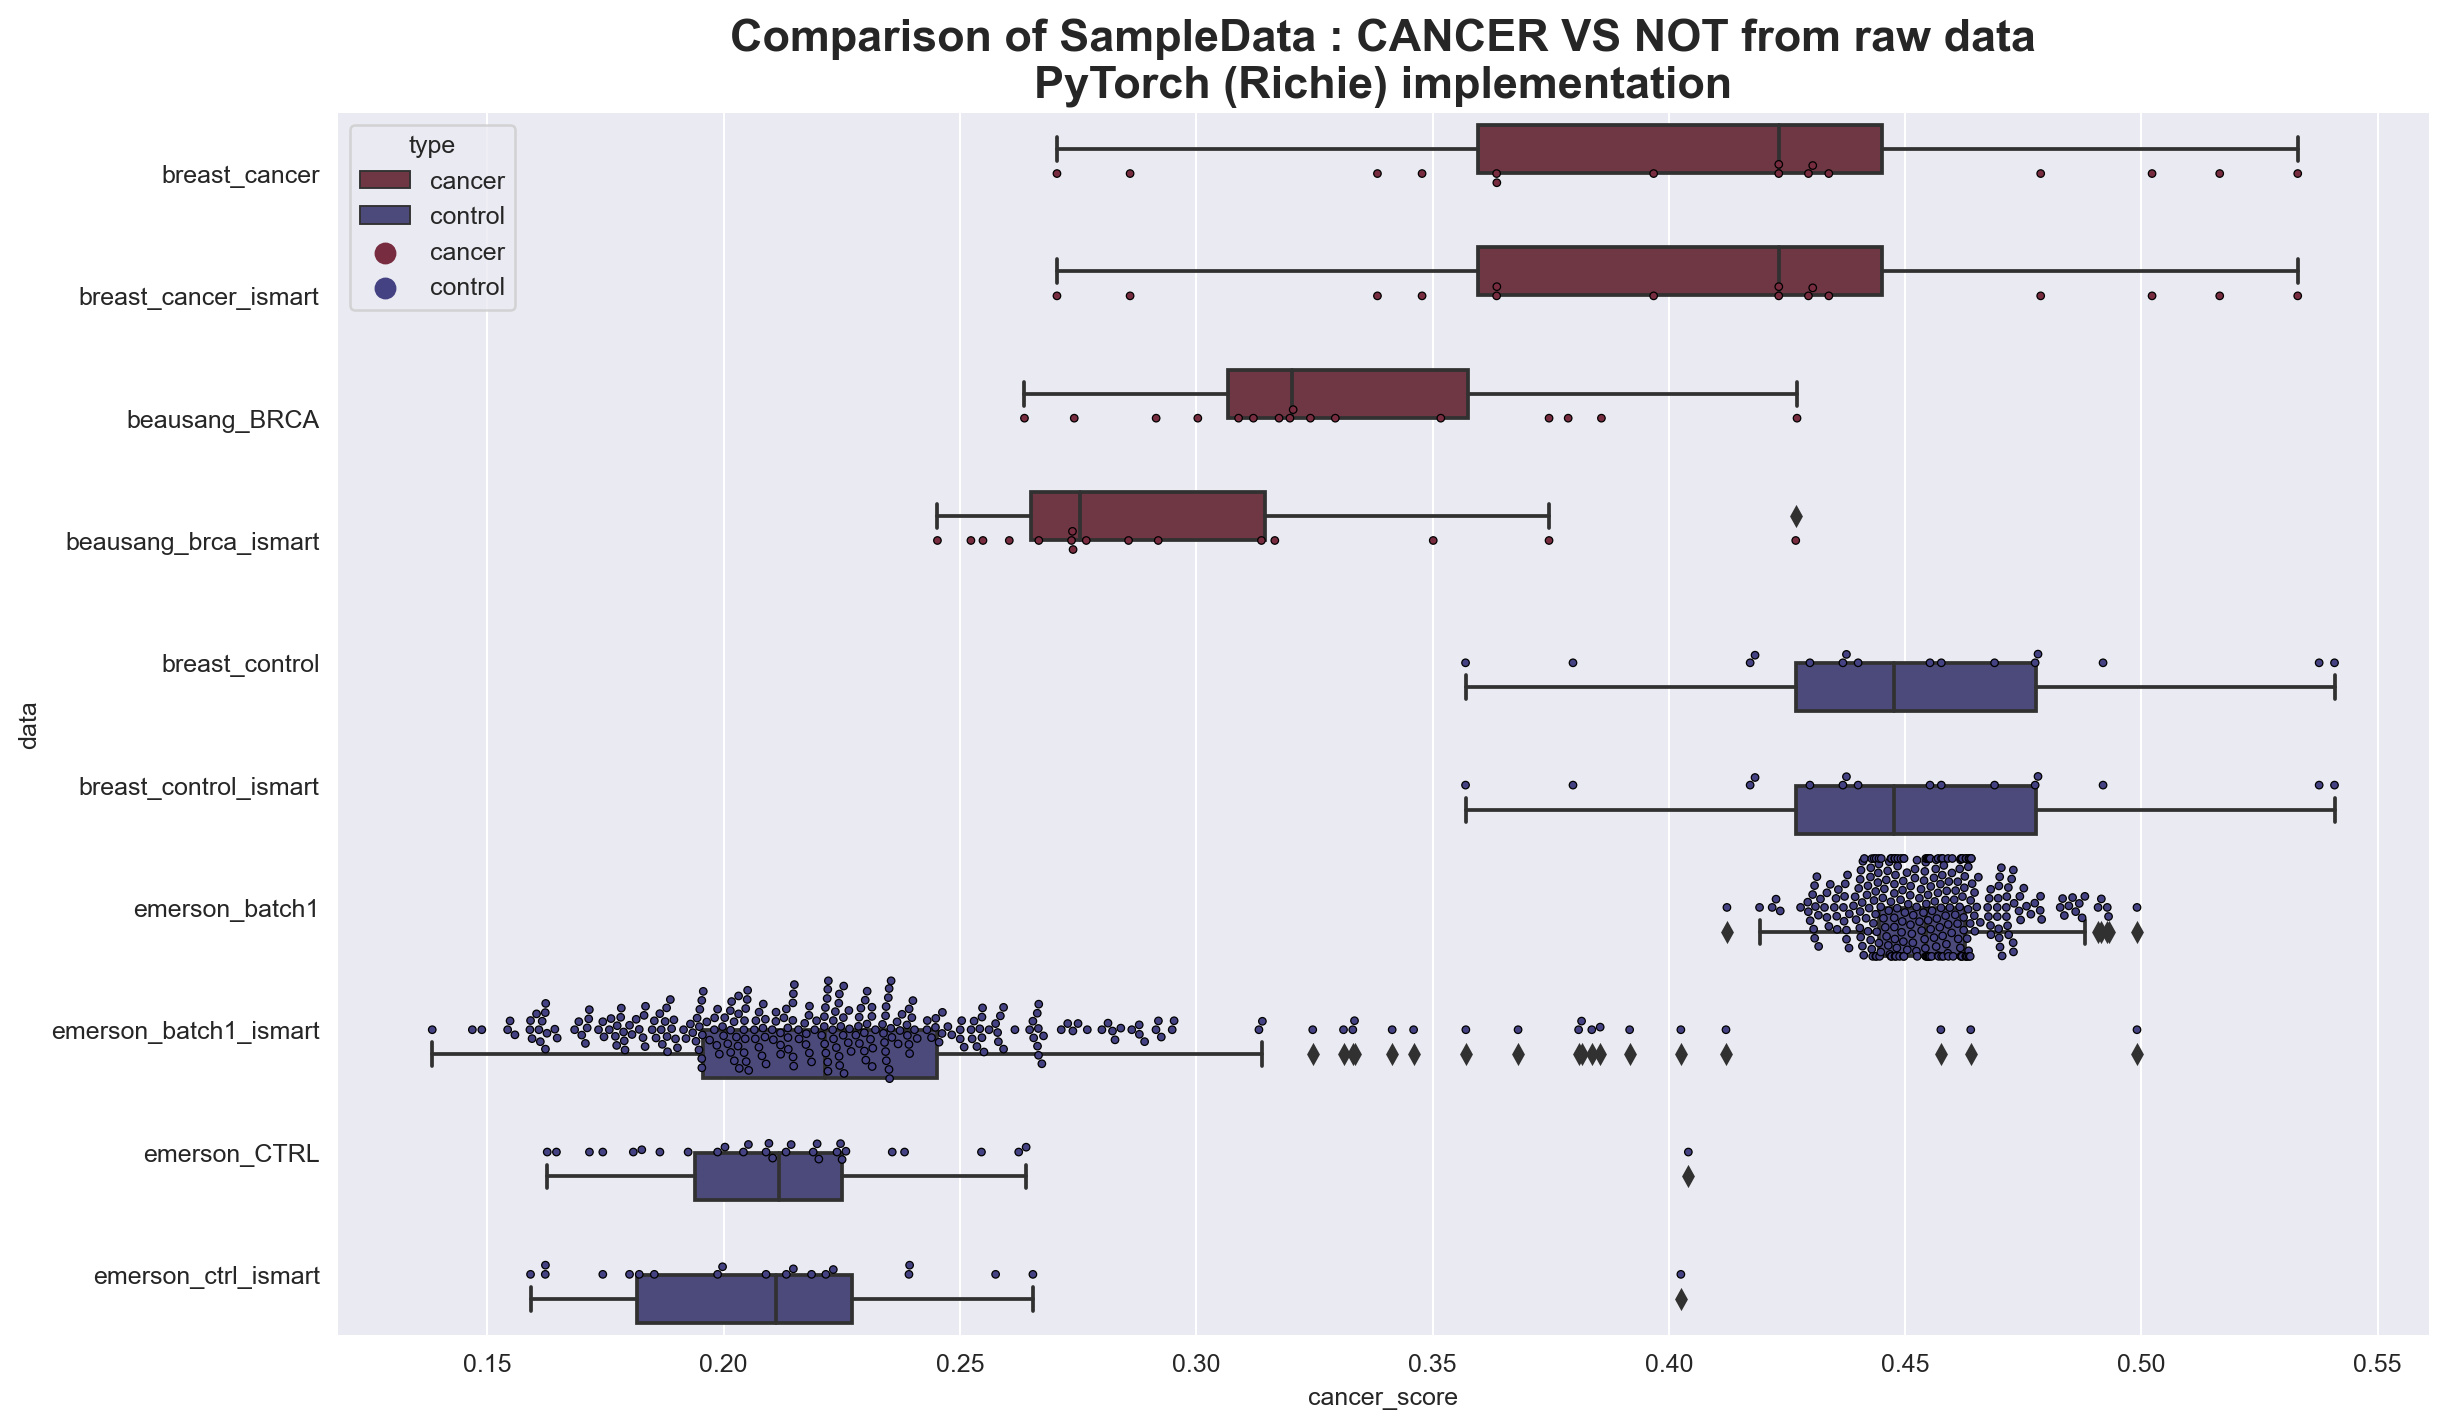

In [263]:
sns.set_palette('icefire_r',n_colors=2)
box(group1, title = 'Comparison of SampleData : CANCER VS NOT from raw data\nPyTorch (Richie) implementation',
    order = ['breast_cancer', 'breast_cancer_ismart','beausang_BRCA', 'beausang_brca_ismart', 'breast_control',
                              'breast_control_ismart', 'emerson_batch1', 'emerson_batch1_ismart','emerson_CTRL', 'emerson_ctrl_ismart'],
   hue = 'type')

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


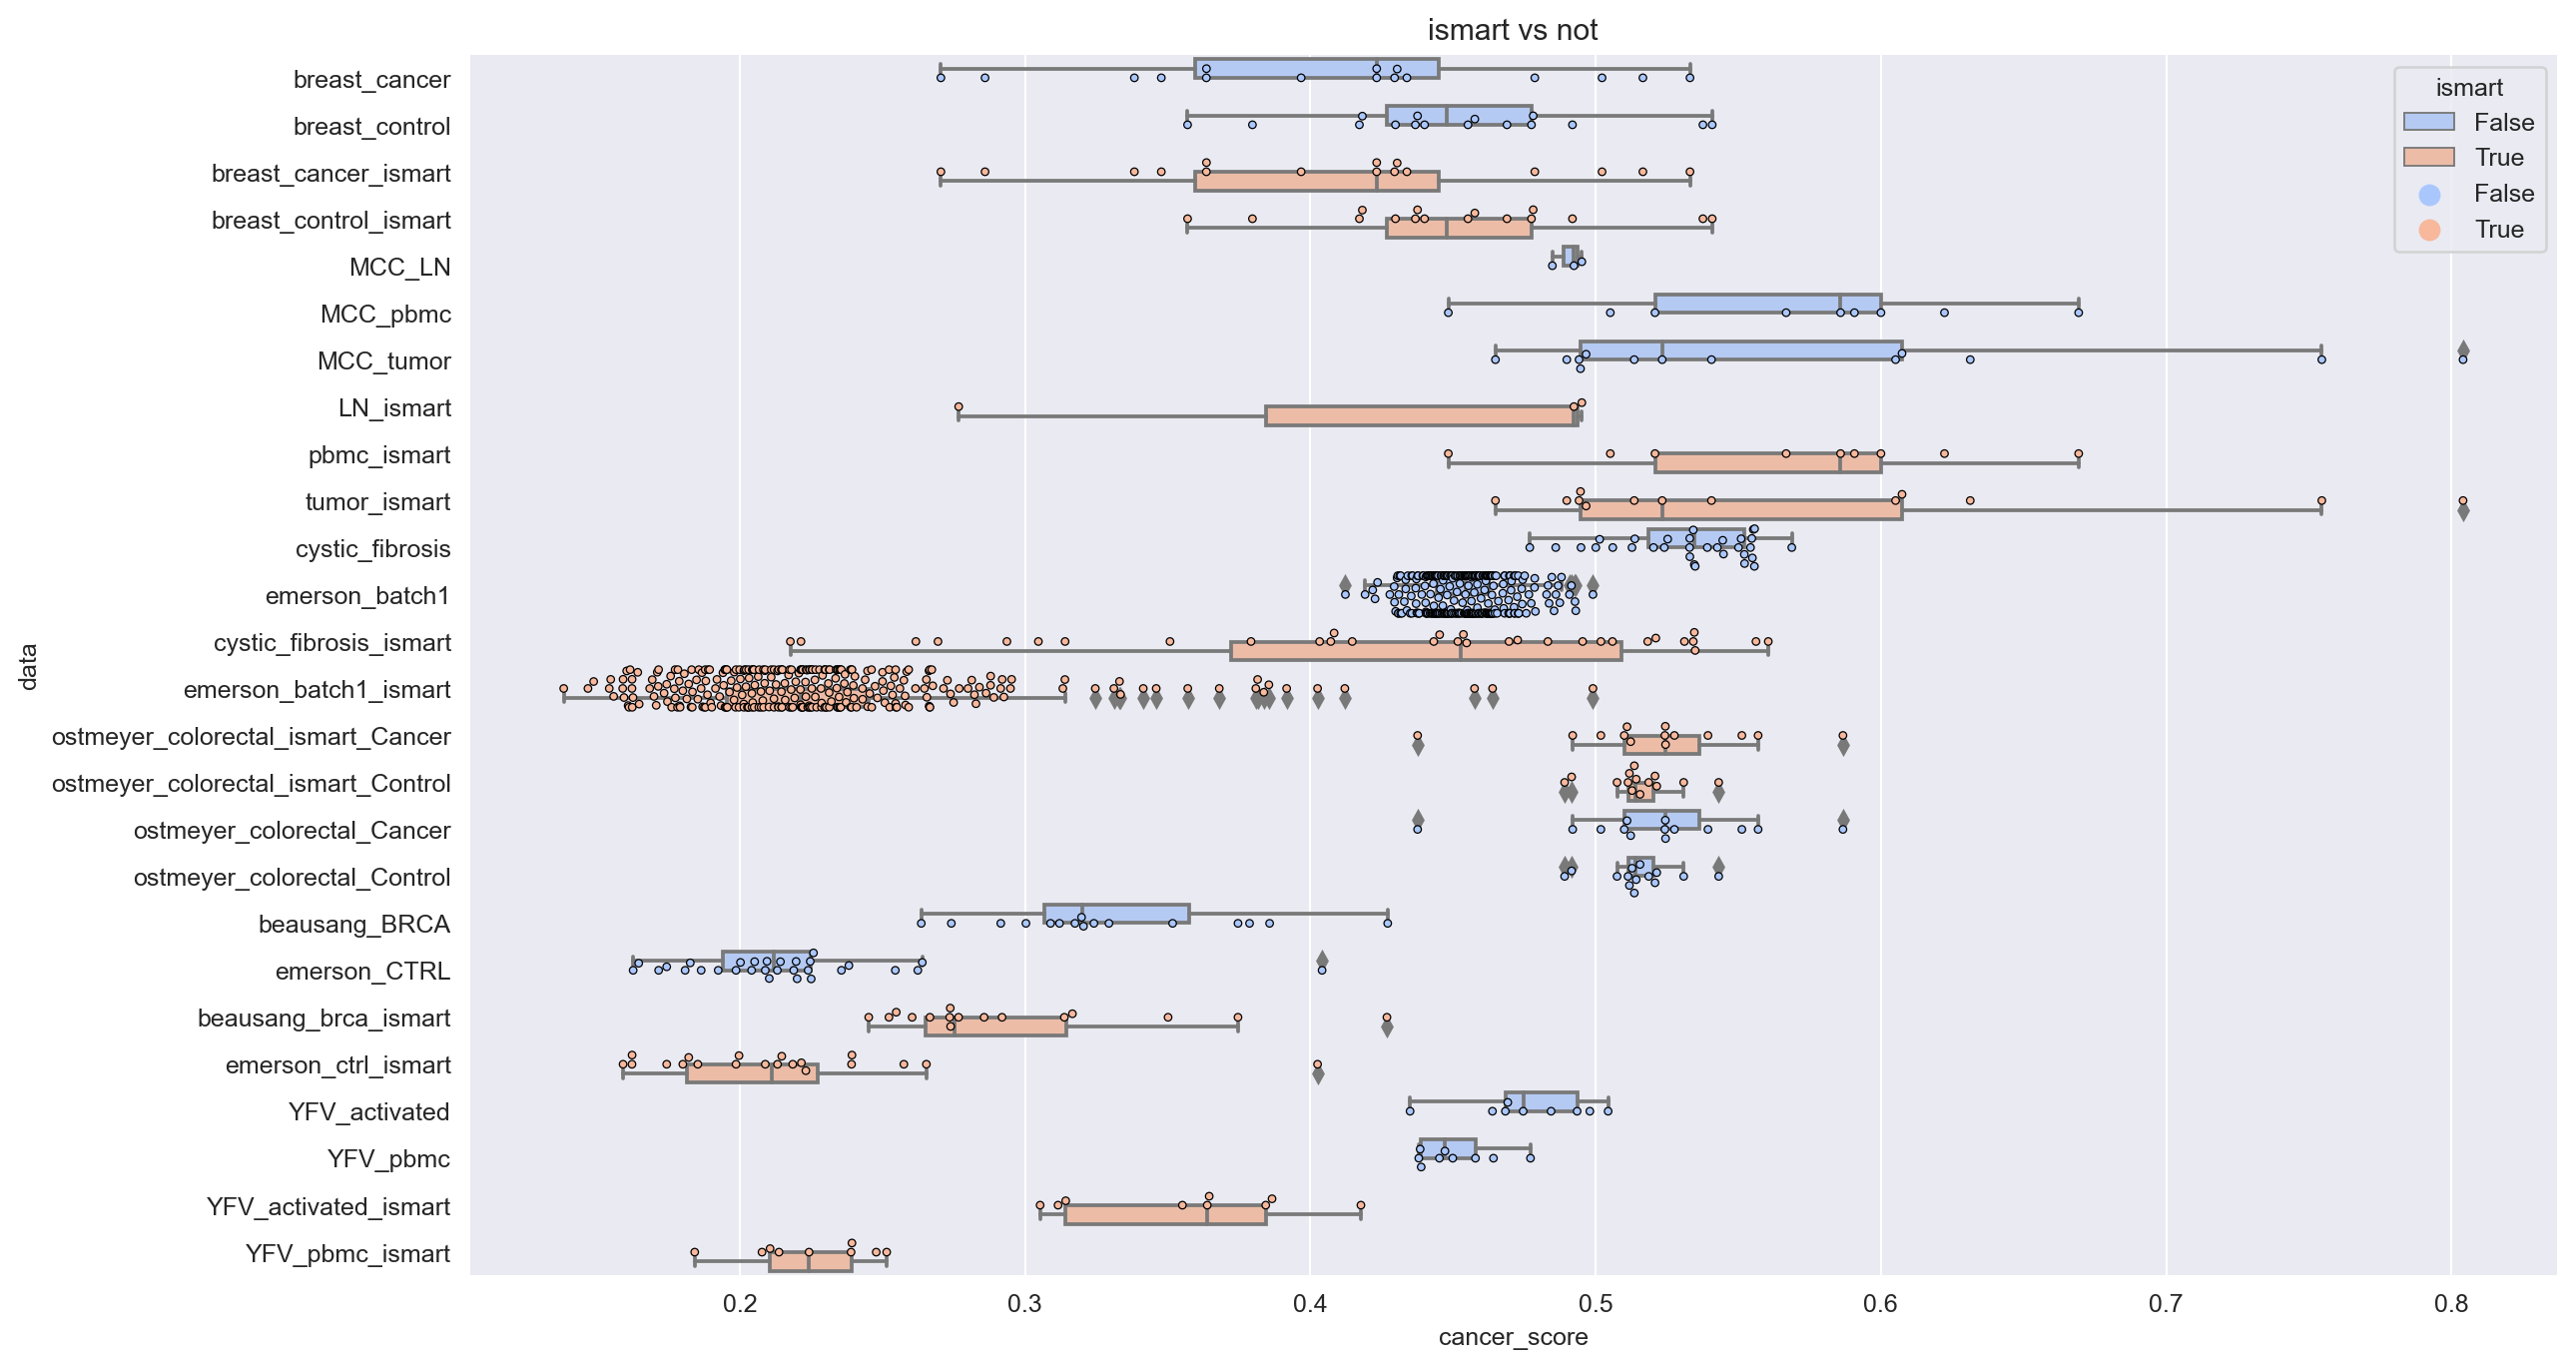

In [247]:
box(results, 'ismart vs not', hue='ismart')

In [181]:
results.query("data.str.contains('ismart')").data.unique()

array(['breast_cancer_ismart', 'breast_control_ismart', 'LN_ismart',
       'pbmc_ismart', 'tumor_ismart', 'cystic_fibrosis_ismart',
       'emerson_batch1_ismart', 'ostmeyer_colorectal_ismart_Cancer',
       'ostmeyer_colorectal_ismart_Control', 'beausang_brca_ismart',
       'emerson_ctrl_ismart', 'YFV_activated_ismart', 'YFV_pbmc_ismart'],
      dtype=object)

In [291]:
sampledata = results.query('data.str.startswith("emerson") or data.str.startswith("beausang") or data.str.startswith("breast")')


(0.1, 0.8)

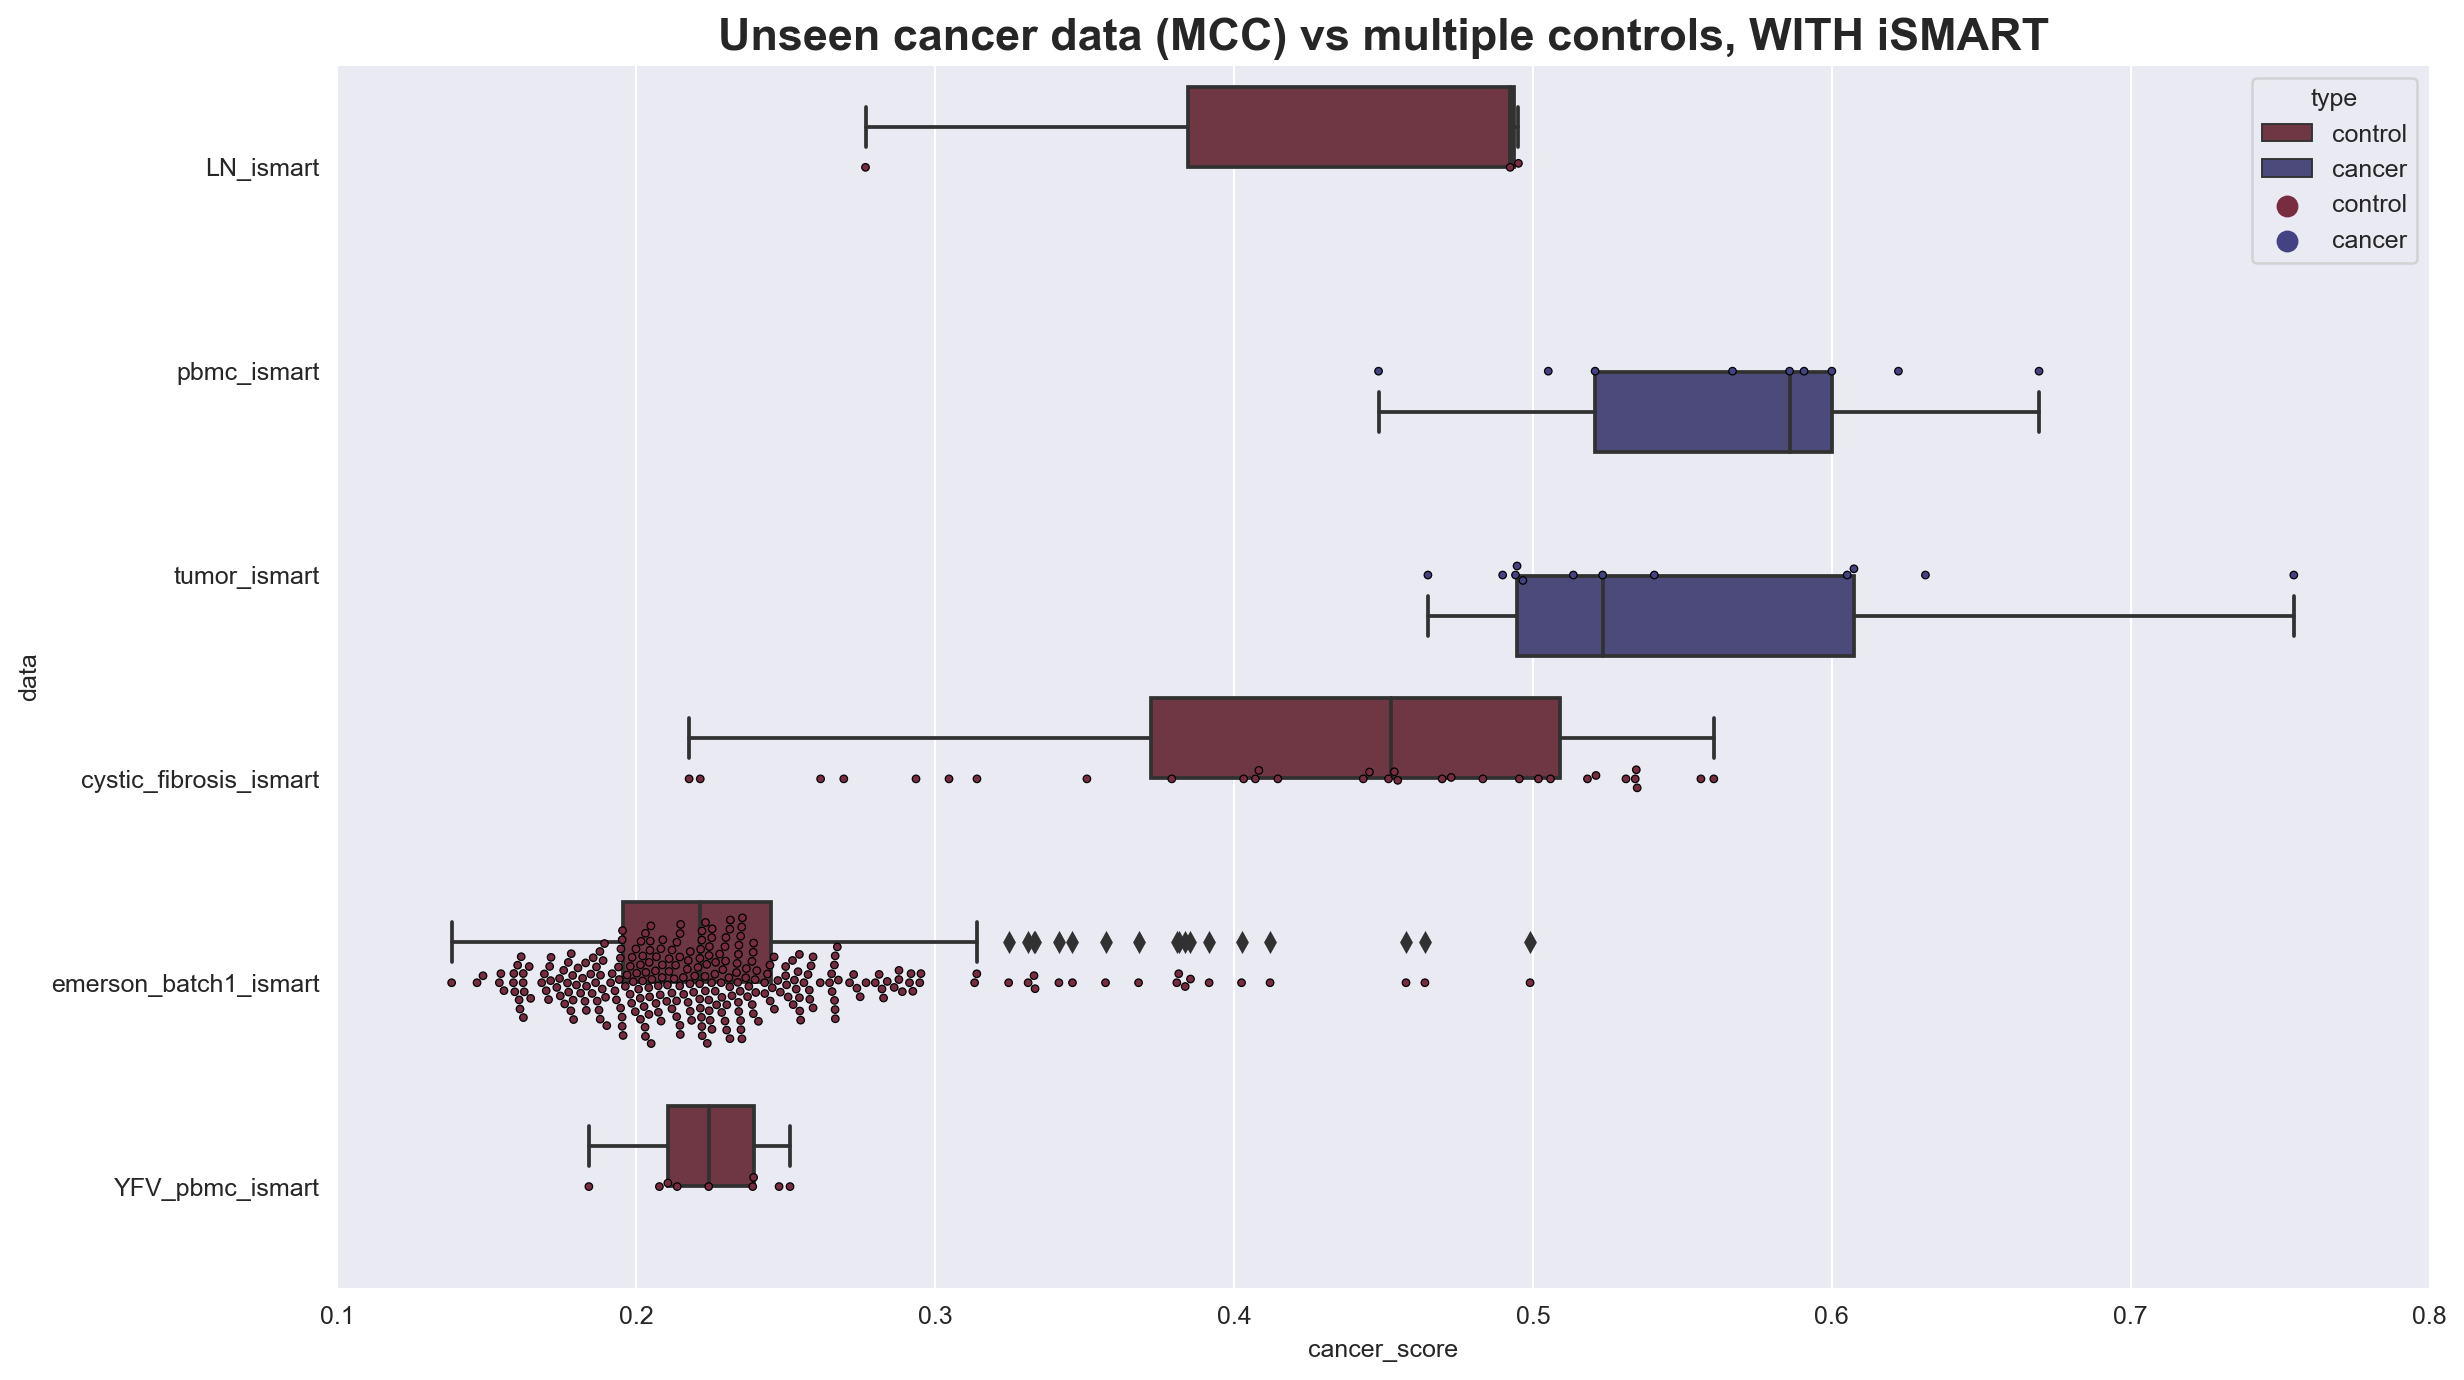

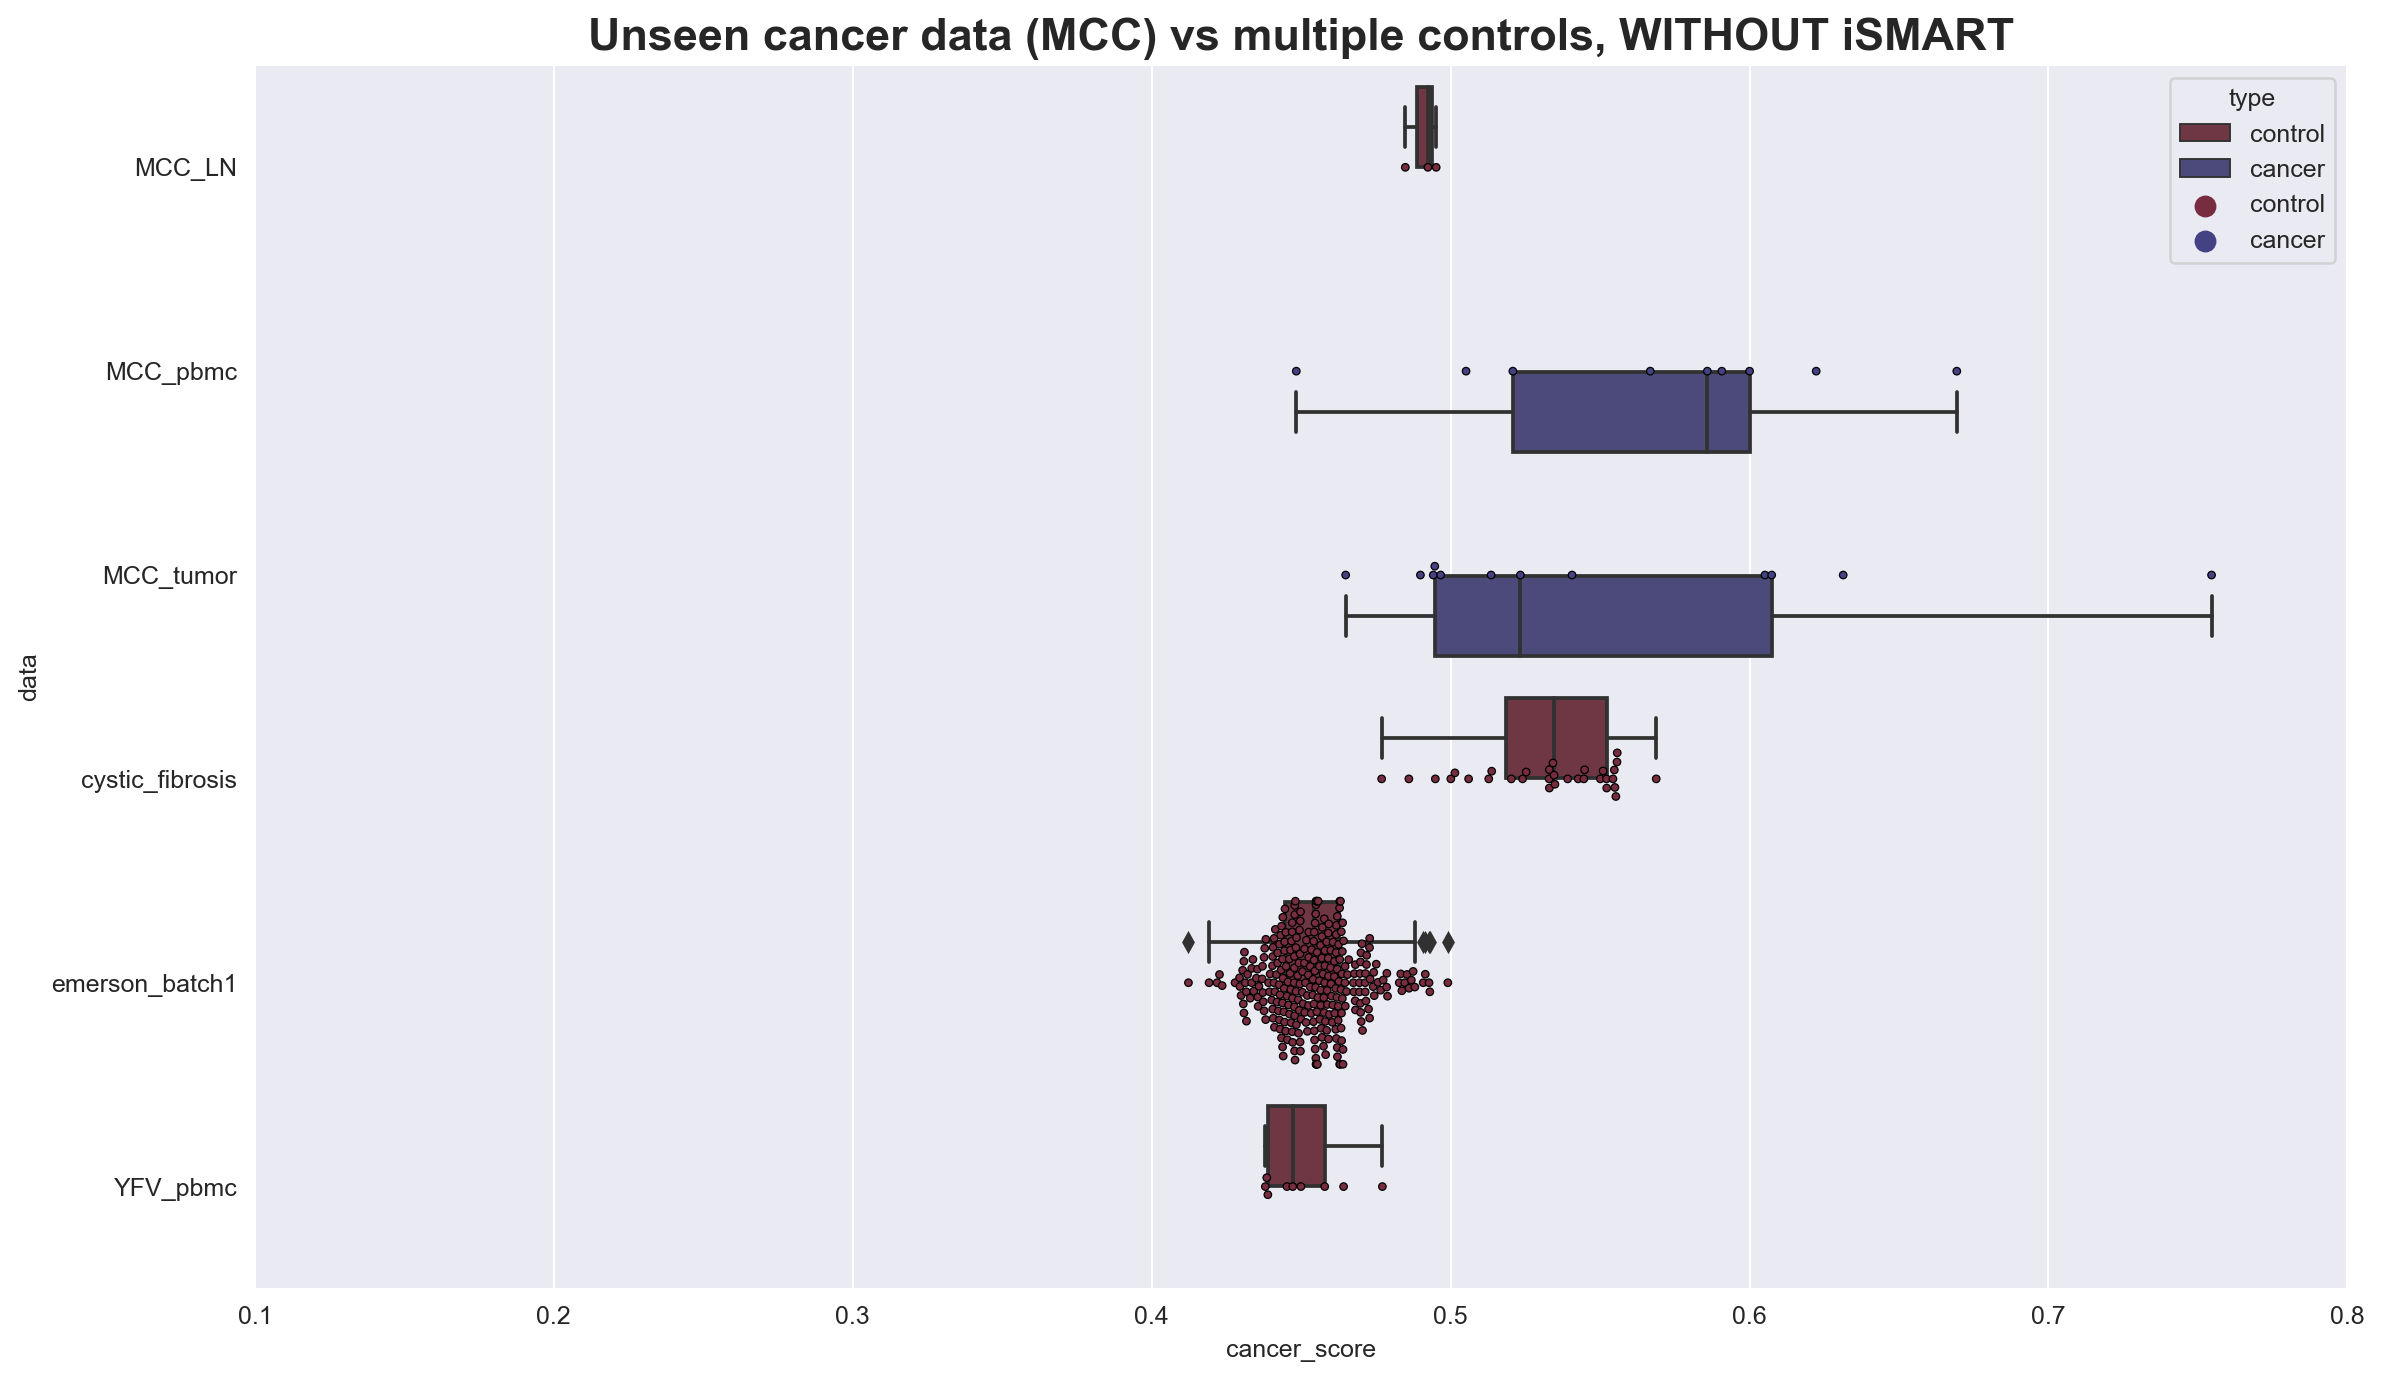

In [294]:
comparison = results.query('data.str.contains("cyst") or data.str.contains("emerson") or data.str.contains("LN")'\
                               'or data.str.contains("PBMC") or data.str.contains("tumor_")'\
                               'or data.str.contains("MCC") or data.str.contains("pbmc")')
comparison = comparison.query('not data.str.contains("CTRL")')
comparison = comparison.query('not data.str.contains("ctrl")')
comparison = comparison.query('not data.str.contains("brca")')

a1= box(comparison.query('ismart==True'),title='Unseen cancer data (MCC) vs multiple controls, WITH iSMART', hue = 'type')
a1.set_xlim([0.1,0.8])
a2= box(comparison.query('ismart==False'),title='Unseen cancer data (MCC) vs multiple controls, WITHOUT iSMART', hue = 'type')
a2.set_xlim([0.1,0.8])


In [298]:
results.data.unique()

array(['brca_pbmc', 'brca_pbmc_ismart', 'breast_cancer', 'breast_control',
       'breast_cancer_ismart', 'breast_control_ismart', 'MCC_LN',
       'MCC_pbmc', 'MCC_tumor', 'LN_ismart', 'pbmc_ismart',
       'tumor_ismart', 'cystic_fibrosis', 'emerson_batch1',
       'cystic_fibrosis_ismart', 'emerson_batch1_ismart',
       'ostmeyer_colorectal_ismart_Cancer',
       'ostmeyer_colorectal_ismart_Control', 'ostmeyer_colorectal_Cancer',
       'ostmeyer_colorectal_Control', 'beausang_BRCA', 'emerson_CTRL',
       'beausang_brca_ismart', 'emerson_ctrl_ismart', 'YFV_activated',
       'YFV_pbmc', 'YFV_activated_ismart', 'YFV_pbmc_ismart'],
      dtype=object)

In [310]:
ostmeyer.query('data=="breast_cancer"')

,name,cancer_score,type,model,data,dummy,ismart
32,BR01T.tsv,0.270518,cancer,richie,breast_cancer,all,False
33,BR05T.tsv,0.363562,cancer,richie,breast_cancer,all,False
34,BR07T.tsv,0.363605,cancer,richie,breast_cancer,all,False
35,BR13T.tsv,0.429552,cancer,richie,breast_cancer,all,False
36,BR14T.tsv,0.285995,cancer,richie,breast_cancer,all,False
37,BR15T.tsv,0.396791,cancer,richie,breast_cancer,all,False
38,BR16T.tsv,0.423267,cancer,richie,breast_cancer,all,False
39,BR17T.tsv,0.533095,cancer,richie,breast_cancer,all,False
40,BR18T.tsv,0.433861,cancer,richie,breast_cancer,all,False
41,BR19T.tsv,0.502269,cancer,richie,breast_cancer,all,False


C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.1, 0.6)

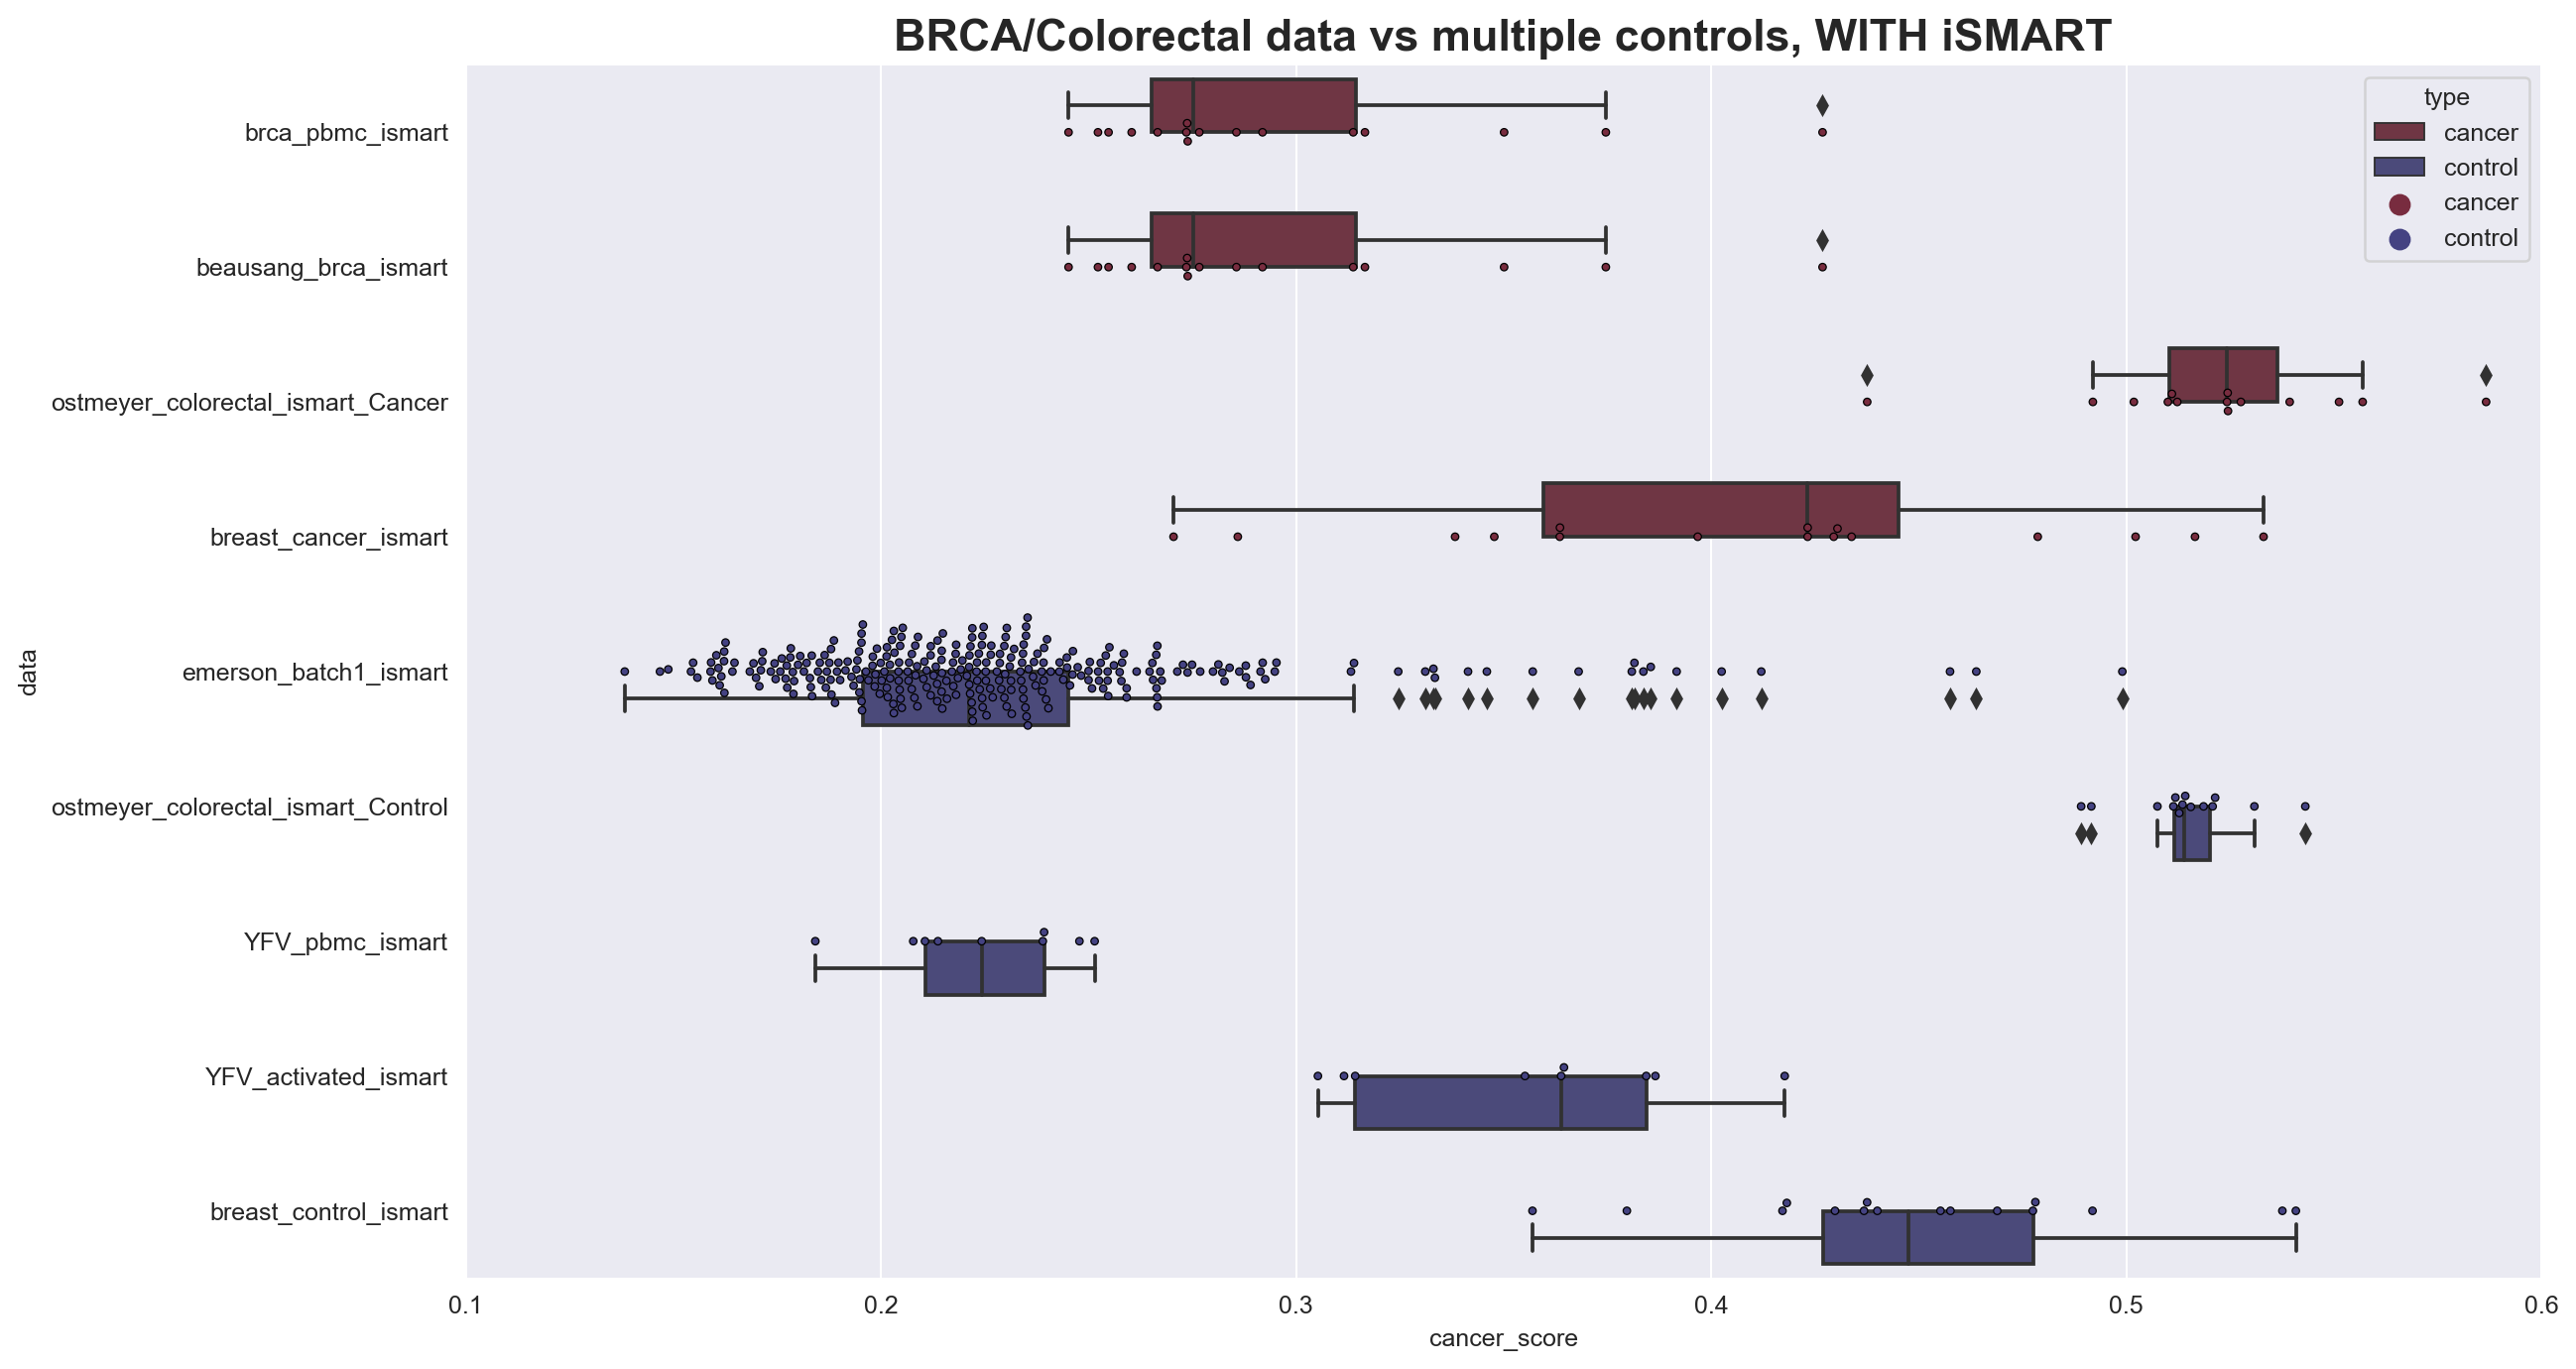

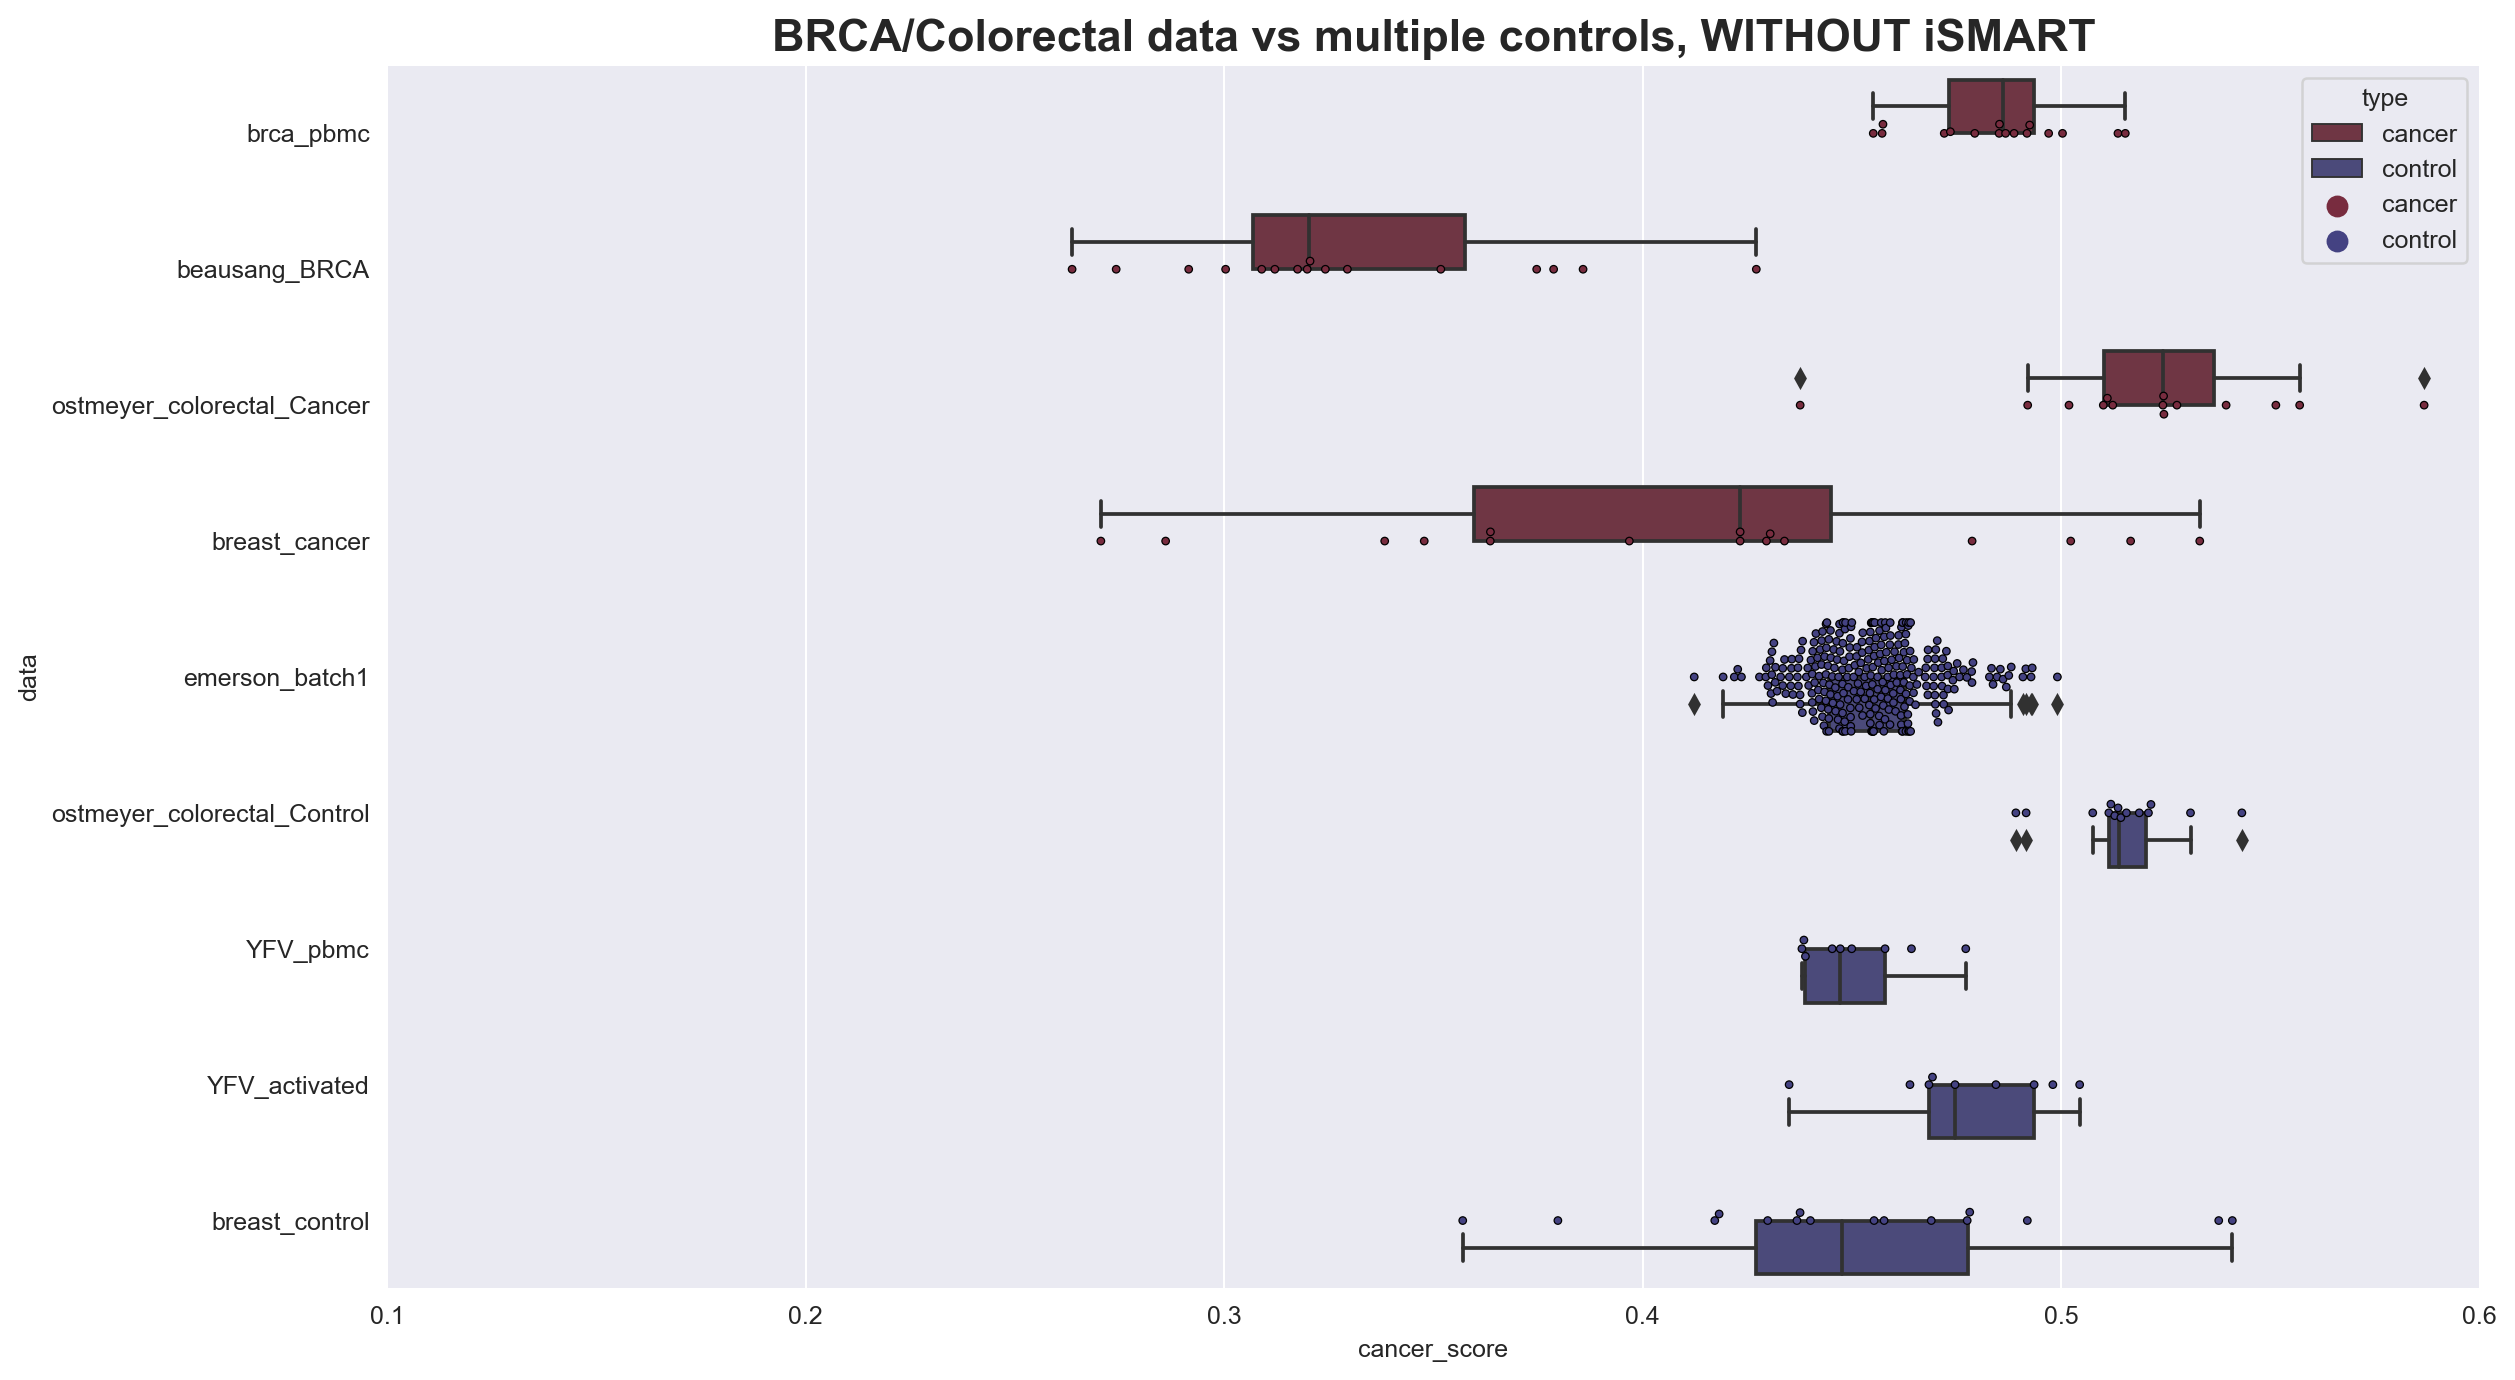

In [313]:
ostmeyer =  results.query('data.str.startswith("ostmeyer") or data.str.startswith("beausang") or data.str.startswith("brca")'\
                          'or data.str.startswith("YFV") or data.str.contains("emerson") or data.str.contains("breast")')
ostmeyer = ostmeyer.query('not data.str.contains("CTRL")')
ostmeyer = ostmeyer.query('not data.str.contains("ctrl")')

a3= box(ostmeyer.query('ismart==True').sort_values('type',ascending=True),title='BRCA/Colorectal data vs multiple controls, WITH iSMART', hue = 'type')
a3.set_xlim([0.1,0.6])
a4= box(ostmeyer.query('ismart==False').sort_values('type',ascending=True),title='BRCA/Colorectal data vs multiple controls, WITHOUT iSMART', hue = 'type')
a4.set_xlim([0.1,0.6])


C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 56.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


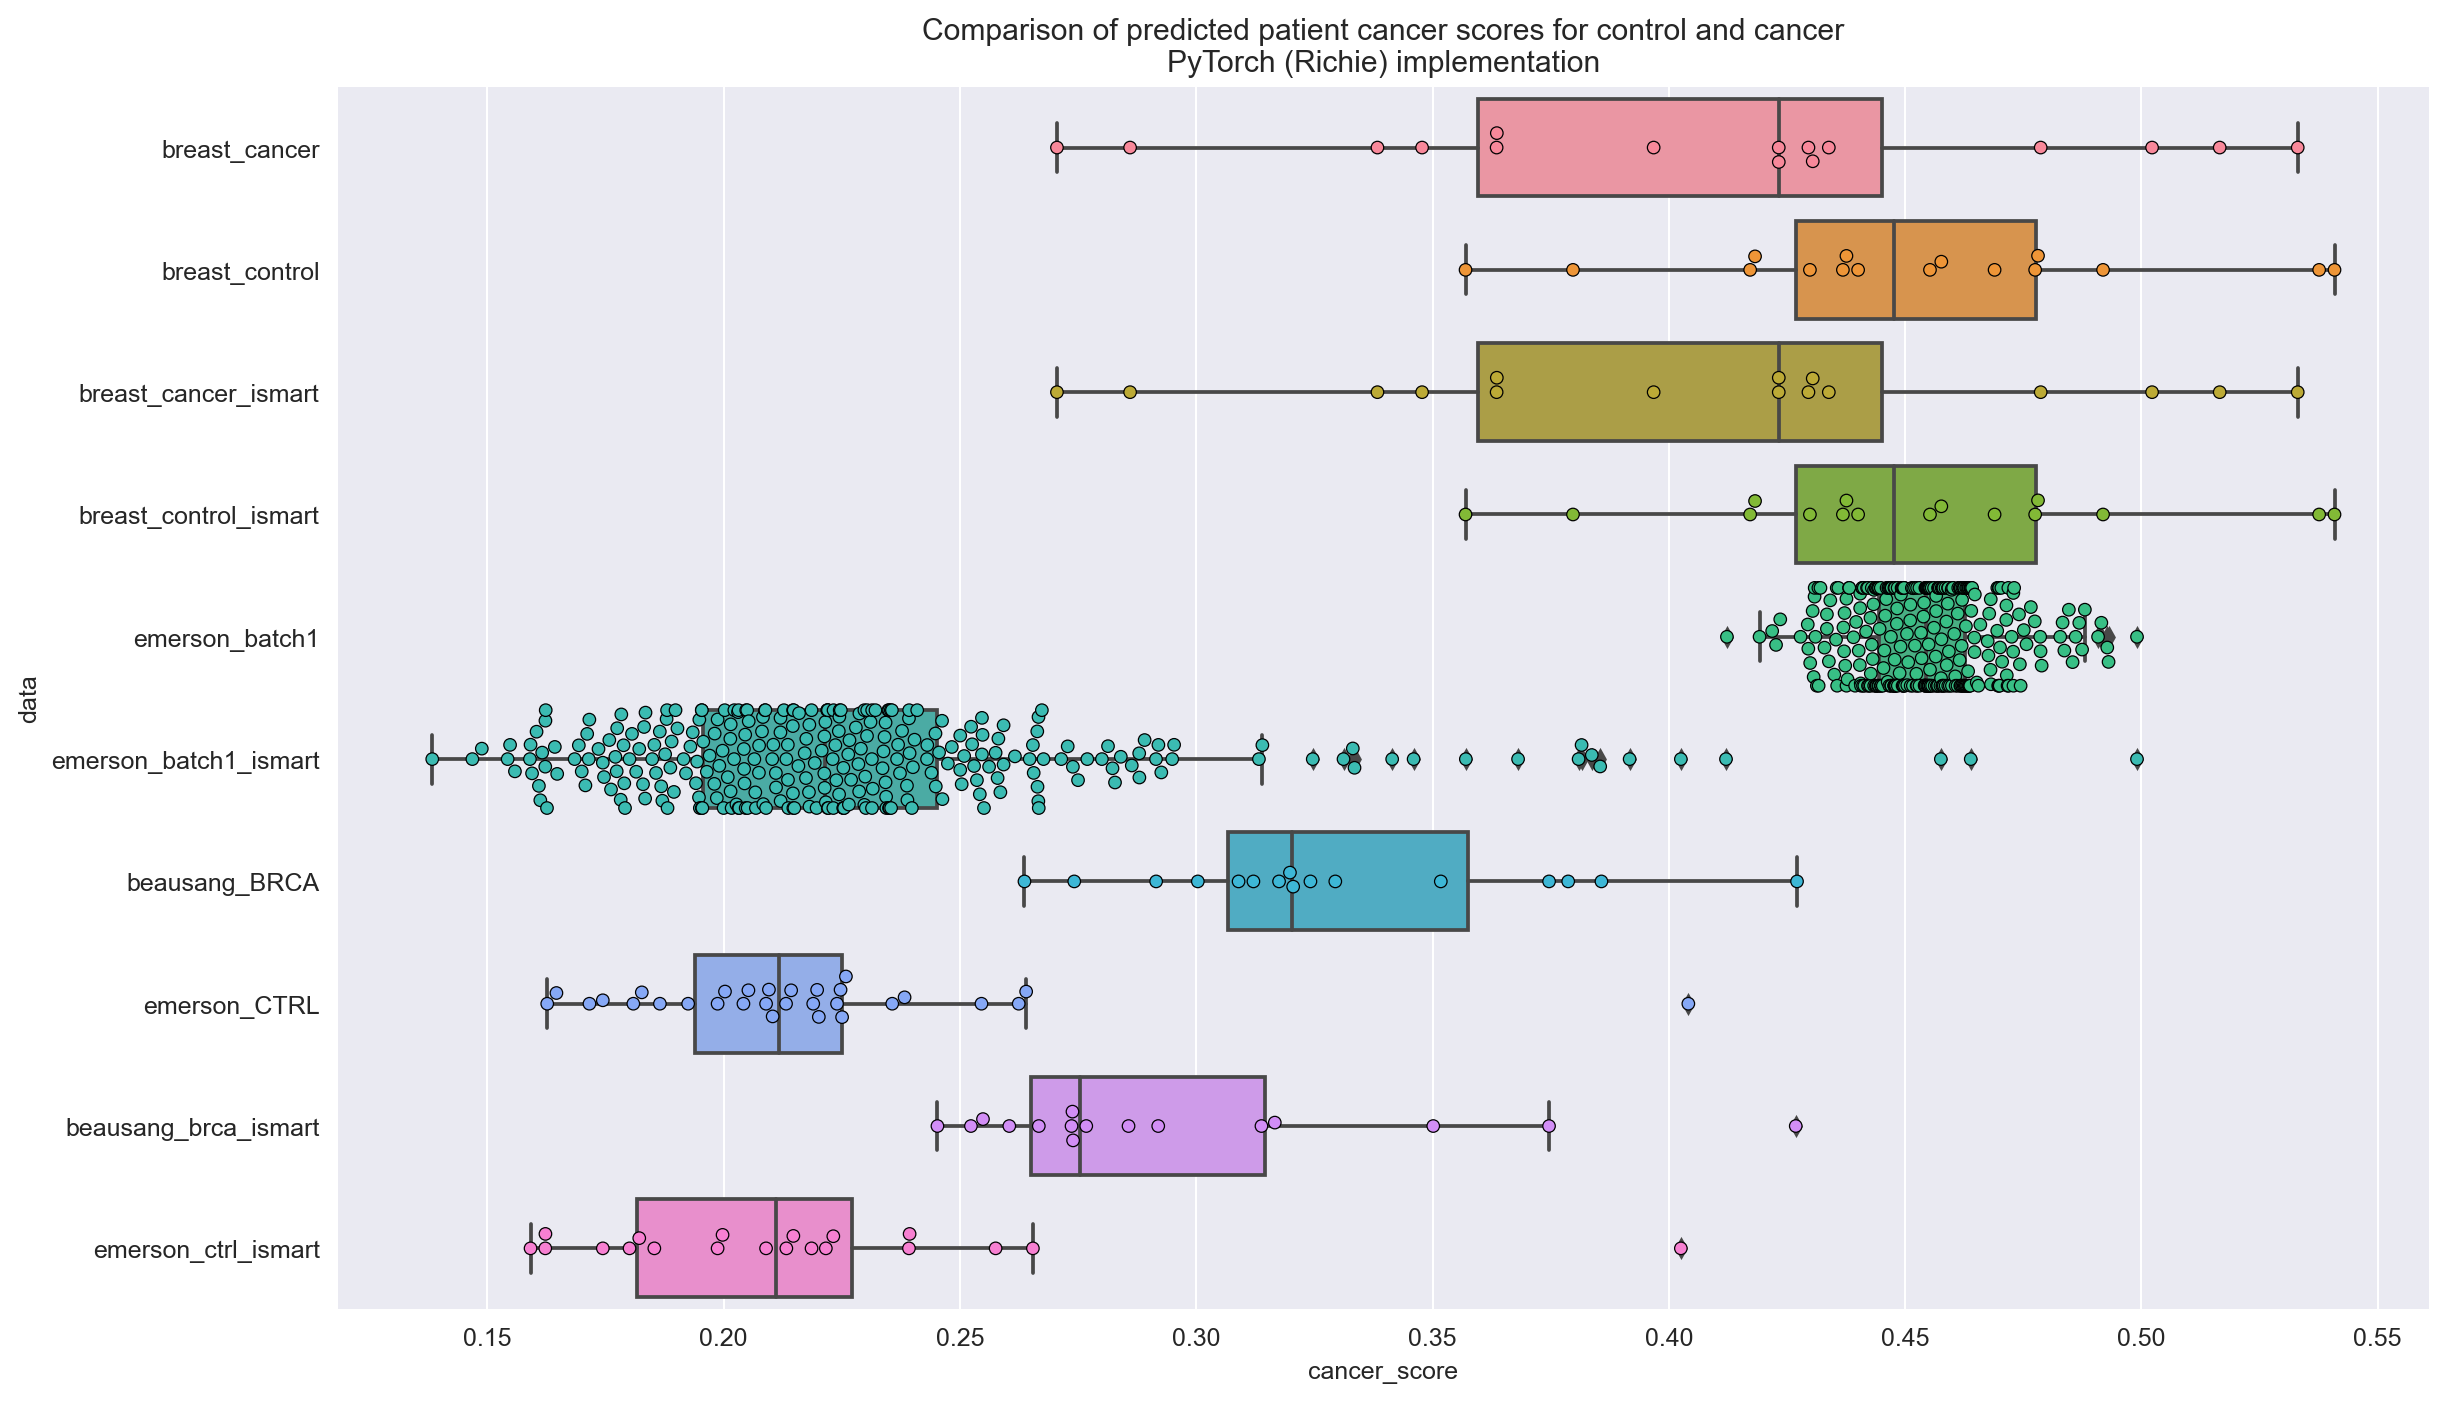

In [238]:
box(sampledata, x='cancer_score', y='data')

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 74.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Comparison of predicted patient cancer scores for control and cancer\nPyTorch (Richie) implementation')

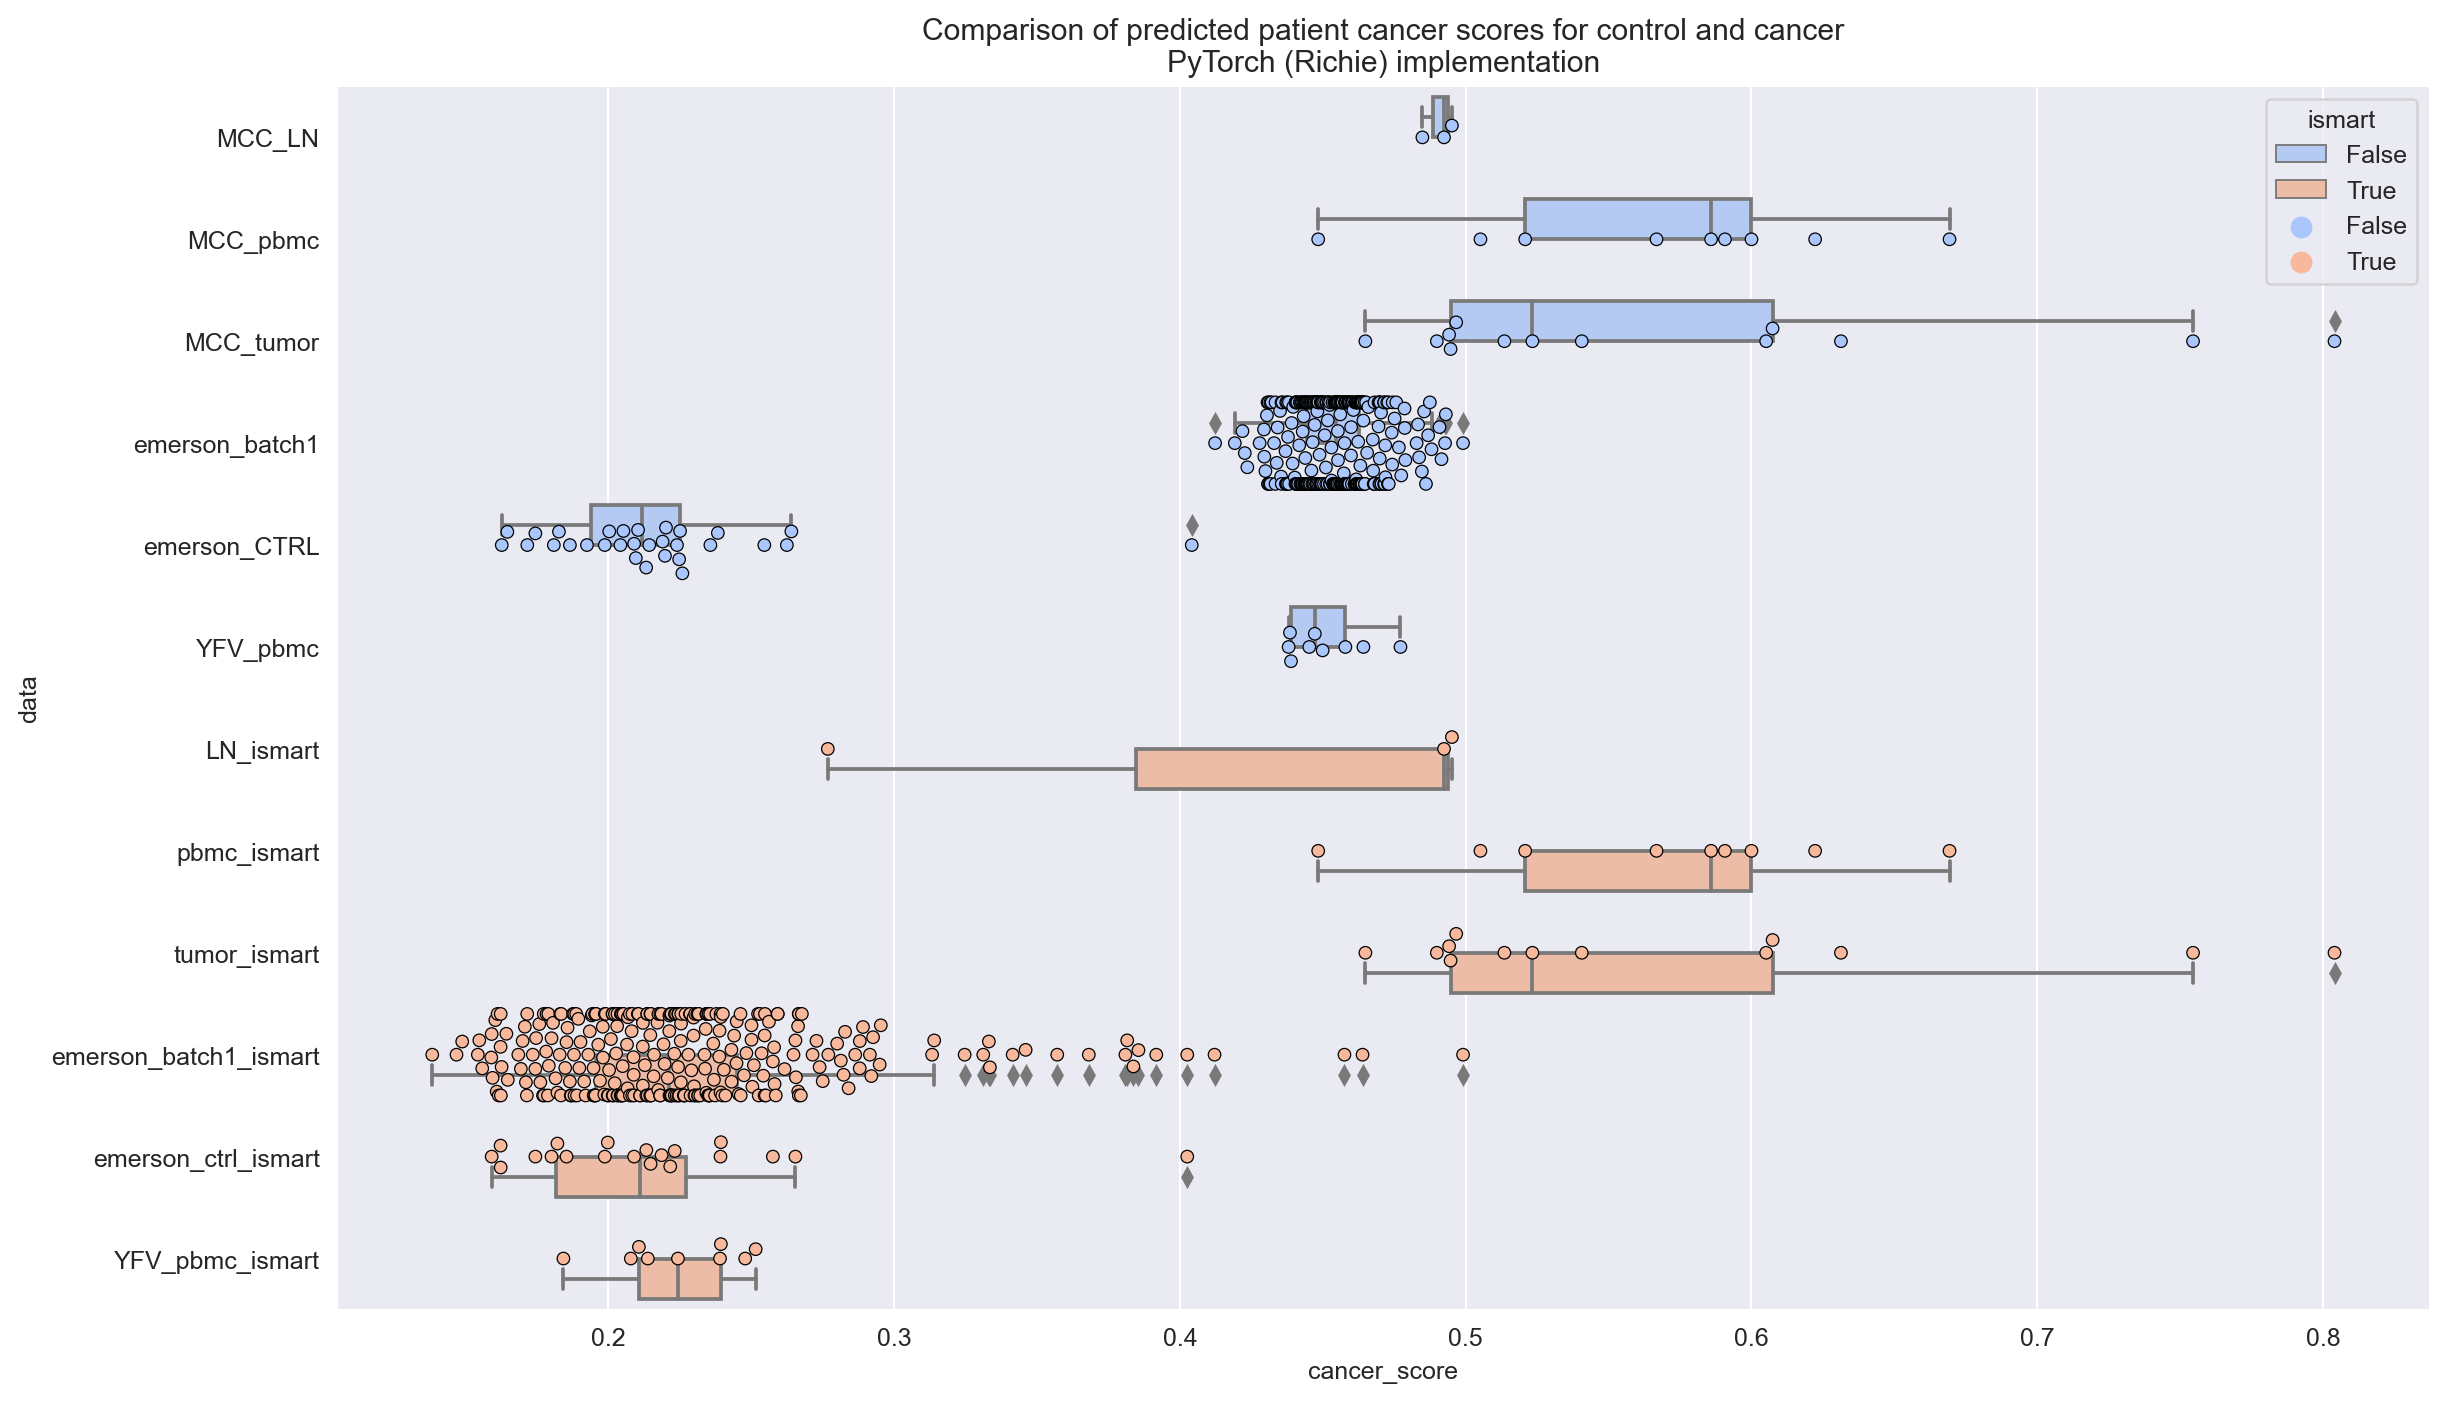

In [180]:
f,a = plt.subplots(1,1, figsize=(15,9))
sns.set_palette('coolwarm',n_colors=2)
sns.boxplot(data=mcc_comparison, x='cancer_score', y='data', hue='ismart', orient='h')
sns.swarmplot(data=mcc_comparison, x='cancer_score', y='data', hue='ismart', orient='h',
              ax = a, edgecolor='black', linewidth=0.5)
a.set_title('Comparison of predicted patient cancer scores for control and cancer'\
            '\nPyTorch (Richie) implementation')

C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 85.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 69.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\richi\Anaconda3\envs\pdm\lib\site-packages\seaborn\categoric

Text(0.5, 1.0, 'Comparison of predicted patient cancer scores for control and cancer\nPyTorch (Richie) implementation')

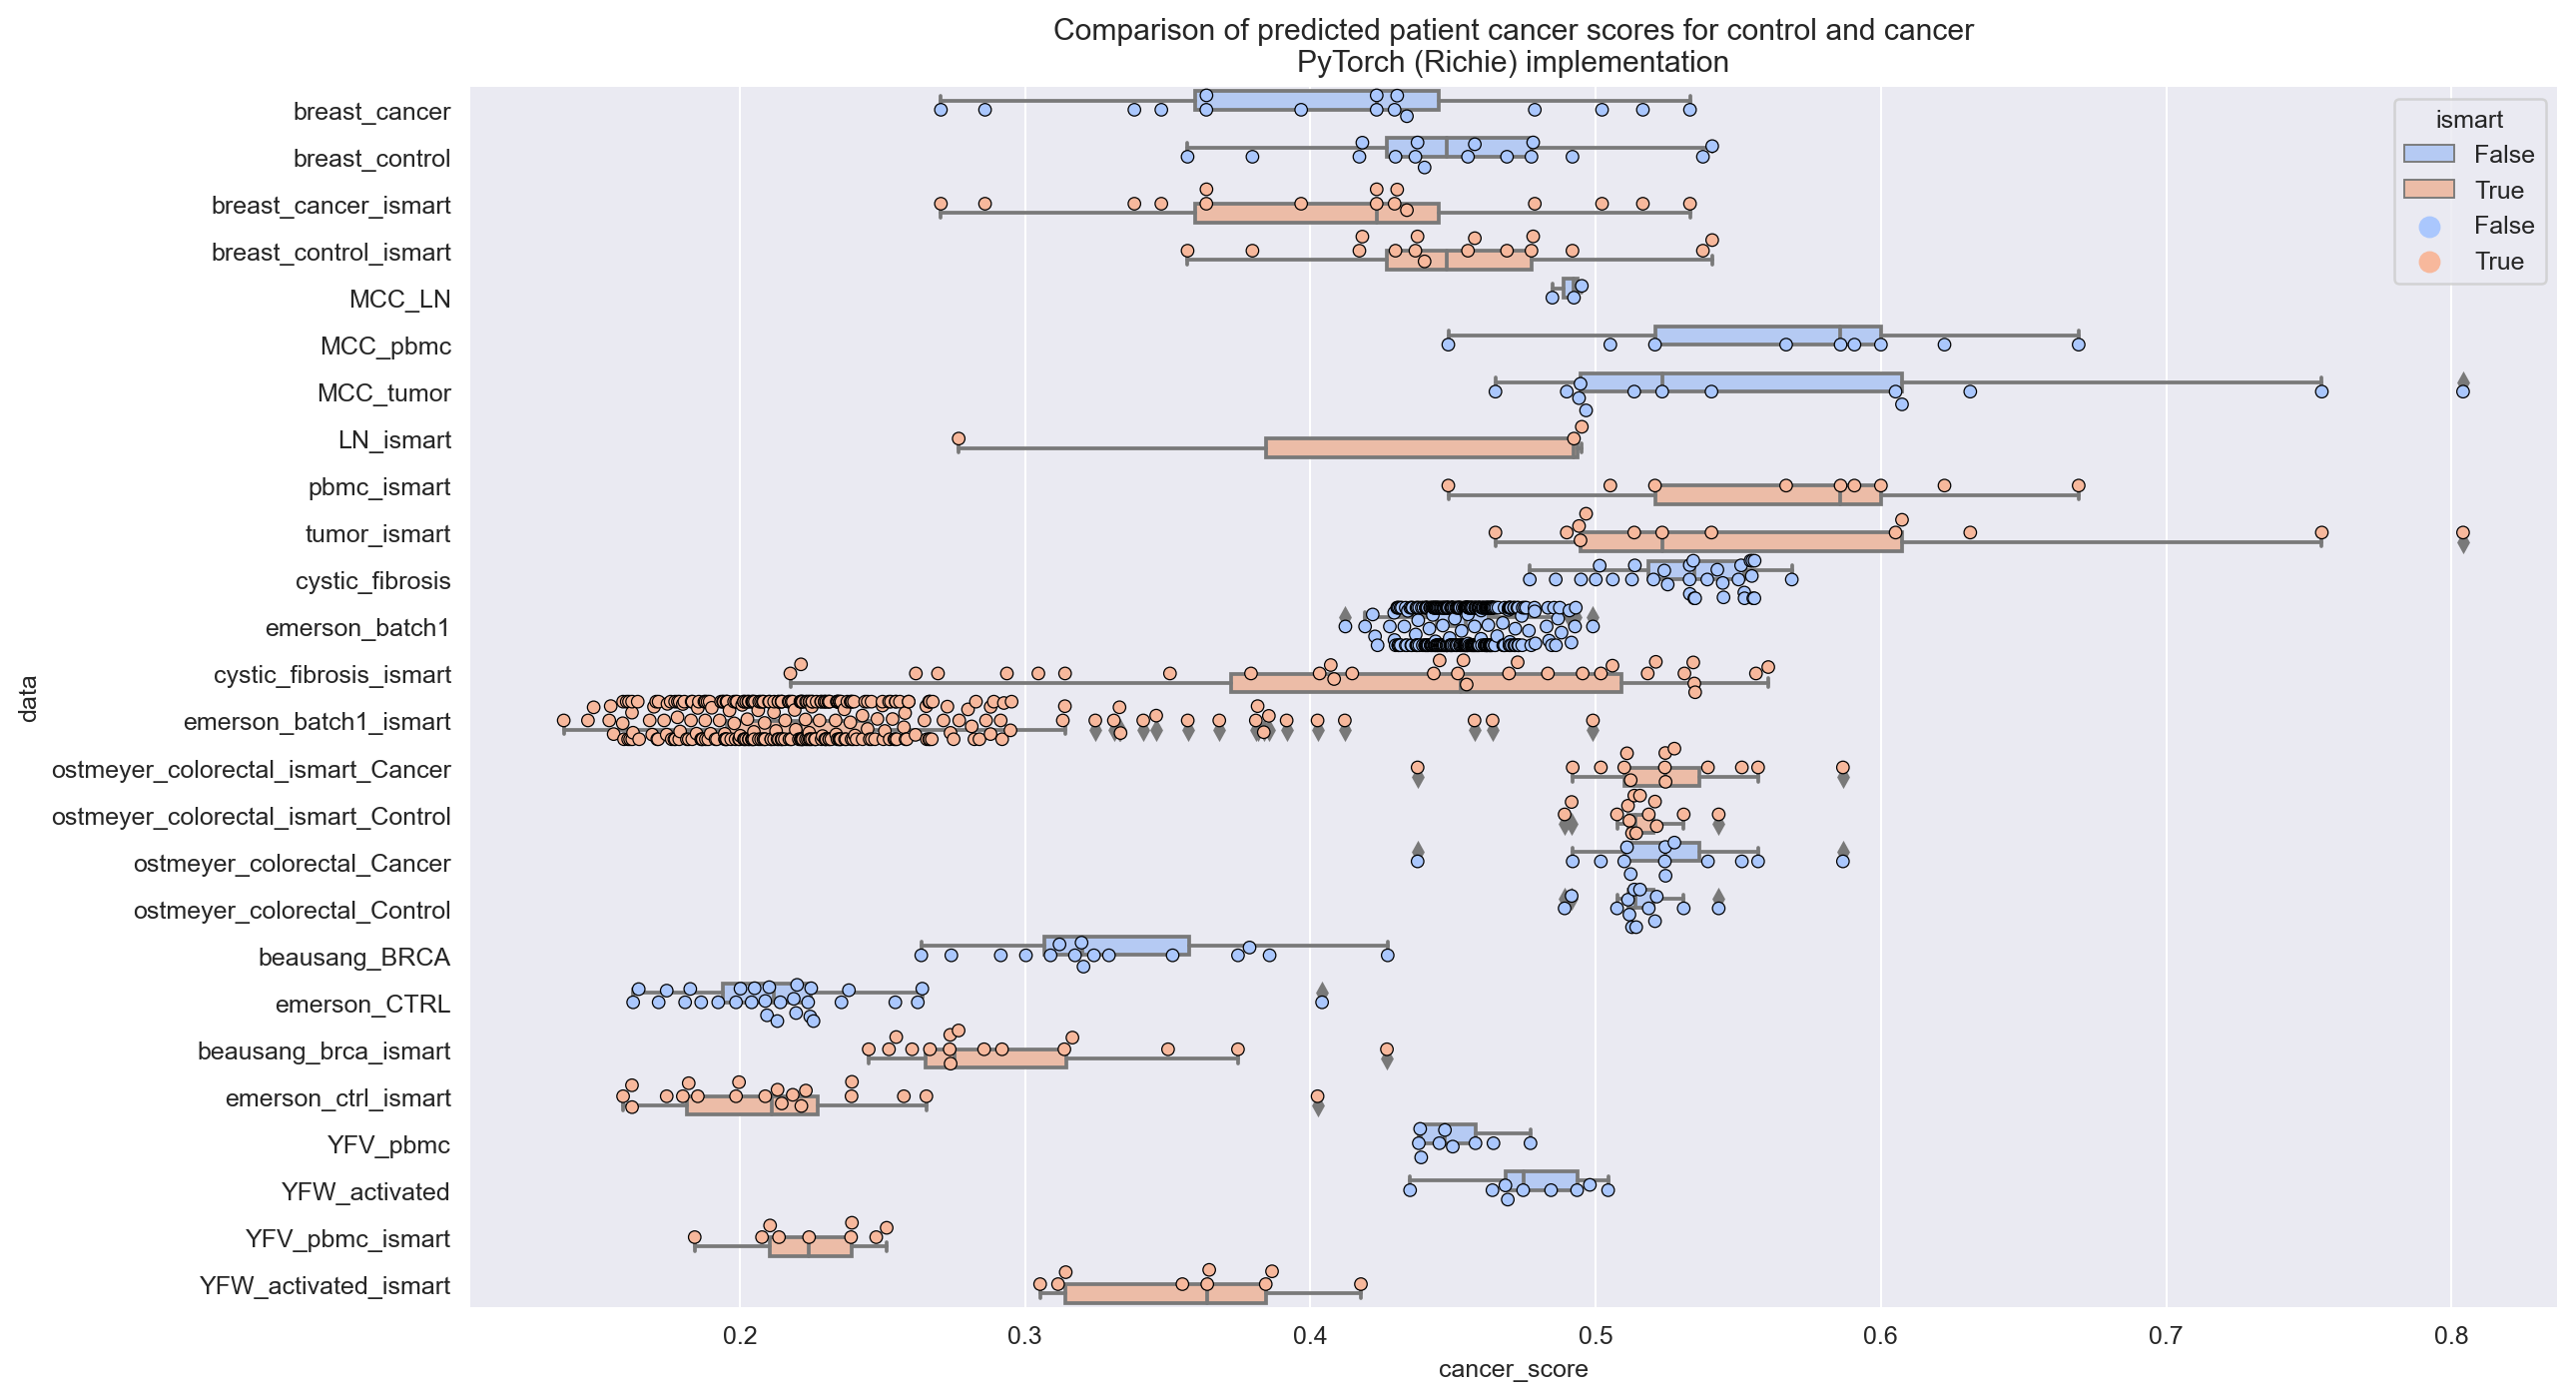

In [122]:
f,a = plt.subplots(1,1, figsize=(15,9))
sns.set_palette('coolwarm',n_colors=2)
sns.boxplot(data=results, x='cancer_score', y='data', hue='ismart', orient='h')
sns.swarmplot(data=results, x='cancer_score', y='data', hue='ismart', orient='h',
              ax = a, edgecolor='black', linewidth=0.5)
a.set_title('Comparison of predicted patient cancer scores for control and cancer'\
            '\nPyTorch (Richie) implementation')